In [84]:
import collections
import functools
from imposm.parser import OSMParser
import json
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from numpy import nan
import numpy as np
import pandas as pd
import pyproj
import requests
import scipy as sp
import rtree
# import seaborn as sb
from scipy import signal
# import shapely
import shapely.geometry
%pylab inline

import data_munging

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Ride Report Method

Here, we use the `match` method from the OSRM API with the code modified to return only the endpoints of segments. This allows us to aggregate over OSM segments since the node IDs are uniquely associated with a lat/lon pair given sufficient precision in the returned coordinates. The API recommends not using every single value for the match method, but I'm giving them regardless because it's easier to code. Down-sampling the ride might actually help to smooth some of the rides. (or perhaps not if we accidentally get a jagged part).

Currently, I am unsure how to mark up OSM data with bumpiness information, as we have 
data that look like this in the raw OSM file:


``
        <way id="23642309" version="25" timestamp="2013-12-26T23:03:24Z" changeset="19653154" uid="28775" user="StellanL">
                <nd ref="258965973"/>
                <nd ref="258023463"/>
                <nd ref="736948618"/>
                <nd ref="258023391"/>
                <nd ref="736948622"/>
                <nd ref="930330659"/>
                <nd ref="736861978"/>
                <nd ref="930330542"/>
                <nd ref="930330544"/>
                <nd ref="929808660"/>
                <nd ref="736934948"/>
                <nd ref="930330644"/>
                <nd ref="736871567"/>
                <nd ref="619628331"/>
                <nd ref="740363293"/>
                <nd ref="931468900"/>
                <tag k="name" v="North Wabash Avenue"/>
                <tag k="highway" v="tertiary"/>
                <tag k="loc_ref" v="44 E"/>
        </way>"
``


My tentative idea is to match up the lat/lons with OSM id using IMPOSM, then find the `nd refs` in the original data and add a property that contains bumpiness information.

In [2]:
rides, readings = data_munging.read_raw_data()
# This is here temporarily both to create a static dataset and because
# some of the newer android readings are bogus and need to be removed.
rides = rides.loc[rides['created_at'] < '2016-03-01', :]
readings = readings.loc[readings['created_at'] < '2016-03-01', :]

In [3]:
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

You can get the IP address by linking up to the Docker container running OSRM and pinging it.

In [4]:
url = 'http://162.243.23.60/osrm-chi-vanilla/'
url = 'http://172.17.0.2:5000/'
nearest_request = url + 'nearest?loc={0},{1}'
match_request = url + 'match?loc={0},{1}&t={2}&loc={3},{4}&t={5}'

In [5]:
def readings_to_match_str(readings):
    data_str = '&loc={0},{1}&t={2}'
    output_str = ''
    elapsed_time = 0
    for i, reading in readings.iterrows():
        elapsed_time += 1
        new_str = data_str.format(str(reading['start_lat']), str(reading['start_lon']), str(elapsed_time))
        output_str += new_str
    return url + 'match?' + output_str[1:]

In [6]:
readings_to_match_str(readings.loc[readings['ride_id'] == 128,  :])

'http://172.17.0.2:5000/match?loc=41.9343765406,-87.7126272396&t=1&loc=41.9343547896,-87.7126500384&t=2&loc=41.9343320327,-87.712677531&t=3&loc=41.9343099045,-87.7127067839&t=4&loc=41.934289746,-87.7127305047&t=5&loc=41.9342679112,-87.7127554827&t=6&loc=41.9342436036,-87.7127800417&t=7&loc=41.9342211401,-87.7128013317&t=8&loc=41.9341976708,-87.71282346&t=9&loc=41.9341737824,-87.7128460911&t=10&loc=41.934151738,-87.7128689737&t=11&loc=41.9341278496,-87.7128971369&t=12&loc=41.9341003988,-87.712927647&t=13&loc=41.9340715651,-87.7129613423&t=14&loc=41.9340427313,-87.7129932773&t=15&loc=41.934011844,-87.7130246256&t=16&loc=41.9339807053,-87.7130557225&t=17&loc=41.9339525002,-87.7130850592&t=18&loc=41.9339230797,-87.713117078&t=19&loc=41.9338936592,-87.7131512762&t=20&loc=41.9338654541,-87.7131827921&t=21&loc=41.9338368299,-87.7132167389&t=22&loc=41.9338079123,-87.7132548765&t=23&loc=41.9337800425,-87.713291254&t=24&loc=41.9337512087,-87.7133262903&t=25&loc=41.9337217883,-87.7133589798&t=26&

In [7]:
matched_ride = requests.get(readings_to_match_str(readings.loc[readings['ride_id'] == 128,  :])).json()

In [8]:
snapped_points =  pd.DataFrame(matched_ride['matchings'][0]['matched_points'], columns=['lat', 'lon'])

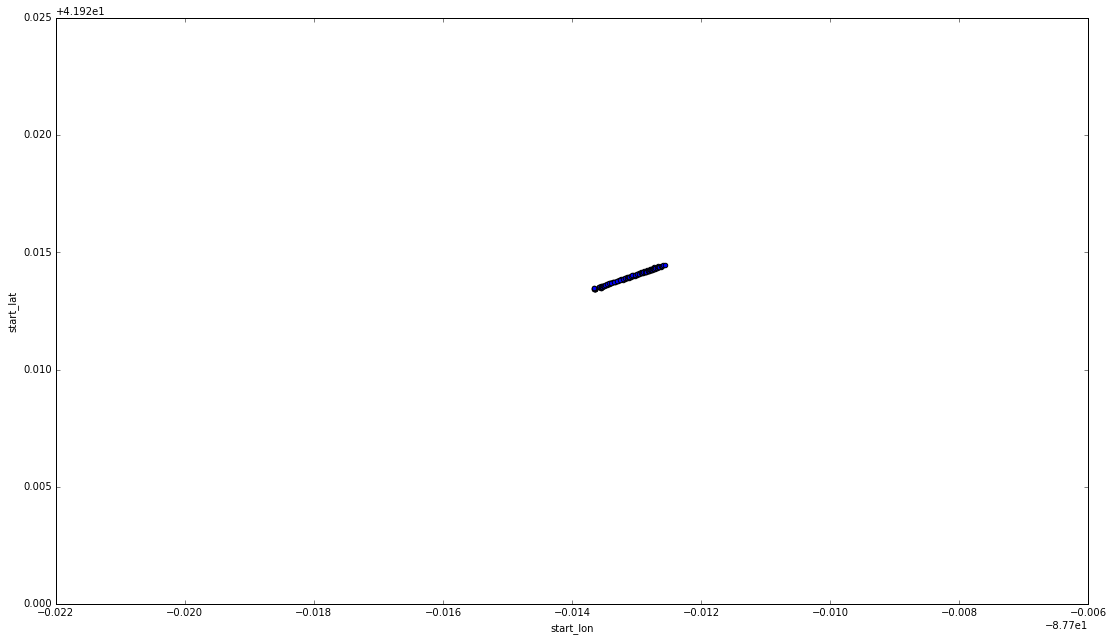

In [9]:
ax = snapped_points.plot(x='lon', y='lat', kind='scatter')
readings.loc[readings['ride_id'] == 128,  :].plot(x='start_lon', y='start_lat', kind='scatter', ax=ax)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [11]:
a_reading = readings.loc[0, :]
test_match_request = match_request.format(a_reading['start_lat'],
                                      a_reading['start_lon'], 
                                      0,
                                      a_reading['end_lat'],
                                      a_reading['end_lon'],
                                      1)
# This does not work because OSRM does not accept floats as times. 
# test_map_request = map_request.format(*tuple(a_reading[['start_lat', 'start_lon', 'start_time',
#                                                 'end_lat', 'end_lon', 'end_time']]))

In [12]:
test_nearest_request = nearest_request.format(a_reading['start_lat'], a_reading['start_lon'])

In [13]:
osrm_response = requests.get(test_match_request).json()
osrm_response['matchings'][0]['matched_points']

[[41.896751, -87.634209], [41.896713, -87.634209]]

In [14]:
osrm_response = requests.get(test_nearest_request).json()
osrm_response['mapped_coordinate']

[41.896751, -87.634209]

In [15]:
readings['snapped_lat'] = 0
readings['snapped_lon'] = 0

In [ ]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     nearest_request = nearest_request.format(reading['start_lat'], reading['end_lat'])
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     total_calls += 1
#     if total_calls > 100:
#         break

In [ ]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']])
# #     print i
# #     print data 
#     osrm_request = nearest_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     readings.loc[i, ['snapped_lat', 'snapped_lon']] = osrm_response['mapped_coordinate']
# #     print osrm_response
#     total_calls += 1
#     if total_calls % 1000 == 0:
#         print(total_calls)

In [16]:
chi_readings = data_munging.filter_readings_to_chicago(readings)
chi_rides = list(set(chi_readings.ride_id))

In [17]:
bad_rides = [128, 129, 5.0, 7.0, 131, 133, 34, 169]

In [18]:
for ride_id in chi_rides:
    if ride_id in bad_rides:
        print('ride_id')
        try:
            print('num readings: ' + str(sum(readings['ride_id'] == ride_id)))
        except:
            print('we had some issues here lol')

ride_id
num readings: 82
ride_id
num readings: 76
ride_id
num readings: 29
ride_id
num readings: 49
ride_id
num readings: 444
ride_id
num readings: 44
ride_id
num readings: 22
ride_id
num readings: 1
ride_id
num readings: 13


In [ ]:
# for ride_id in chi_rides:
#     if pd.notnull(ride_id):
#         complete_snapped_points.loc[complete_snapped_points['ride_id'] == ride_id, ['id']] = readings.loc[readings['ride_id'] == ride_id, ['id']]
#         print(complete_snapped_points.loc[complete_snapped_points['ride_id'] == ride_id, ['id']])
#         print(readings.loc[readings['ride_id'] == ride_id, ['id']])

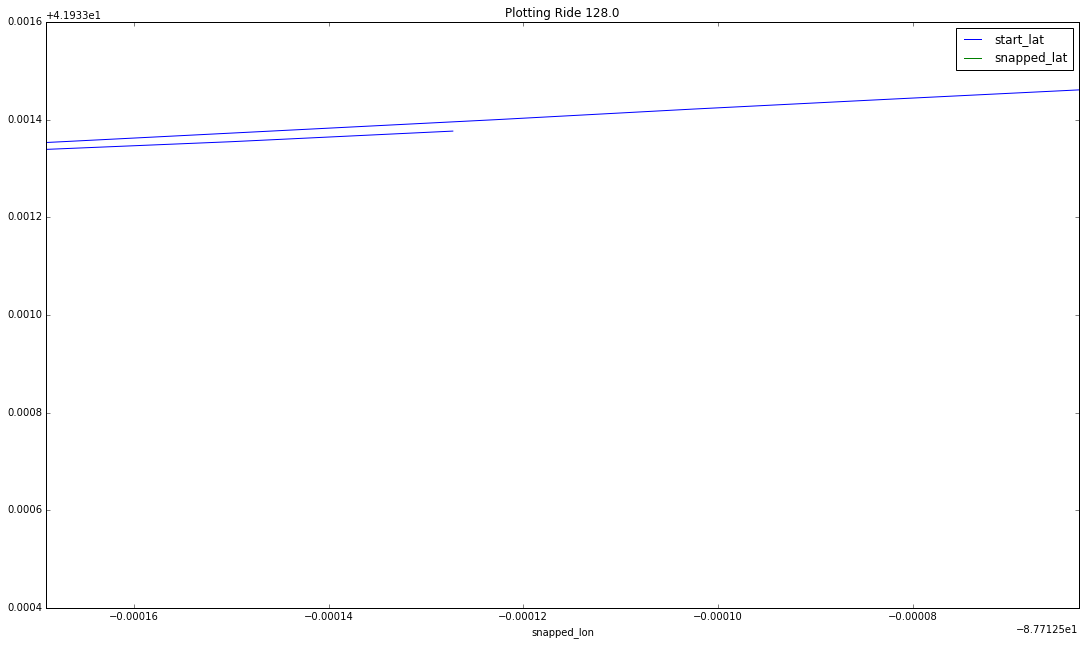

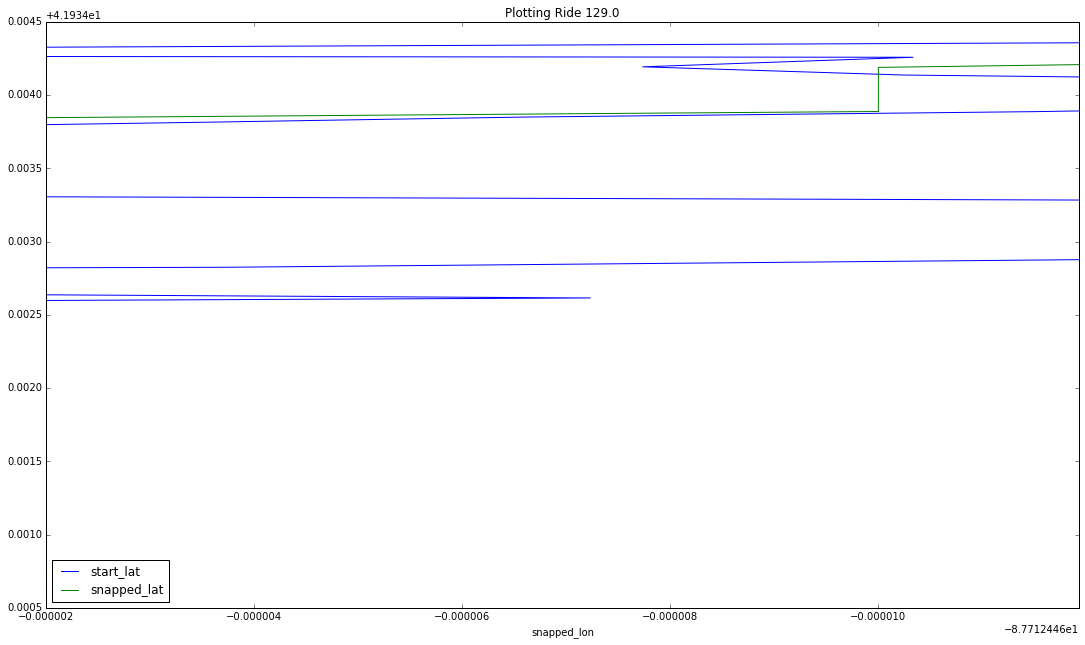

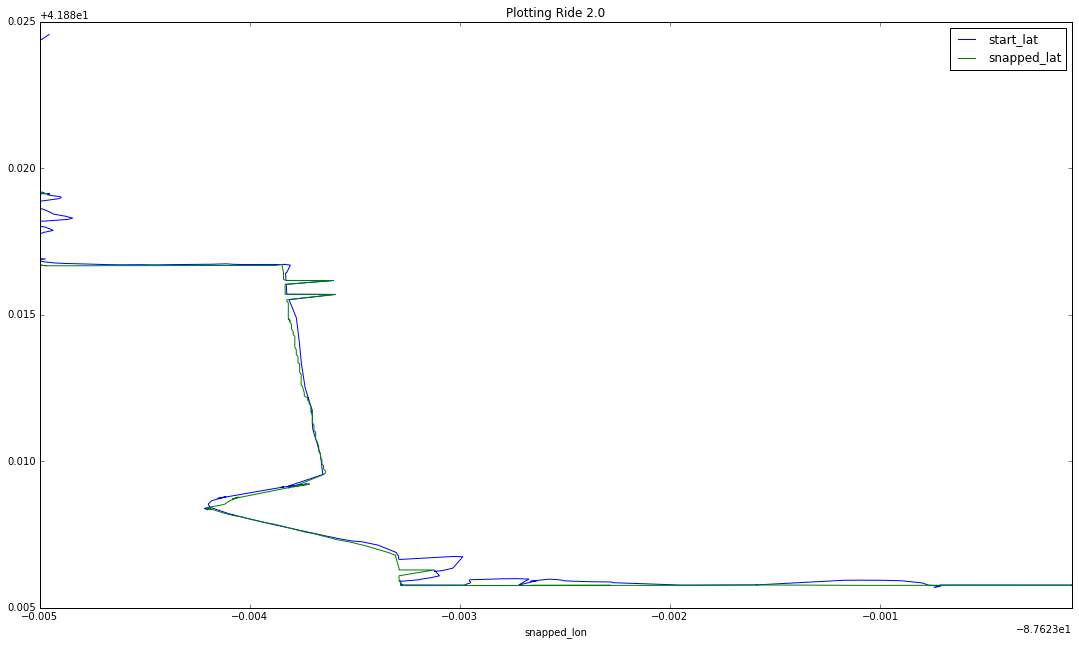

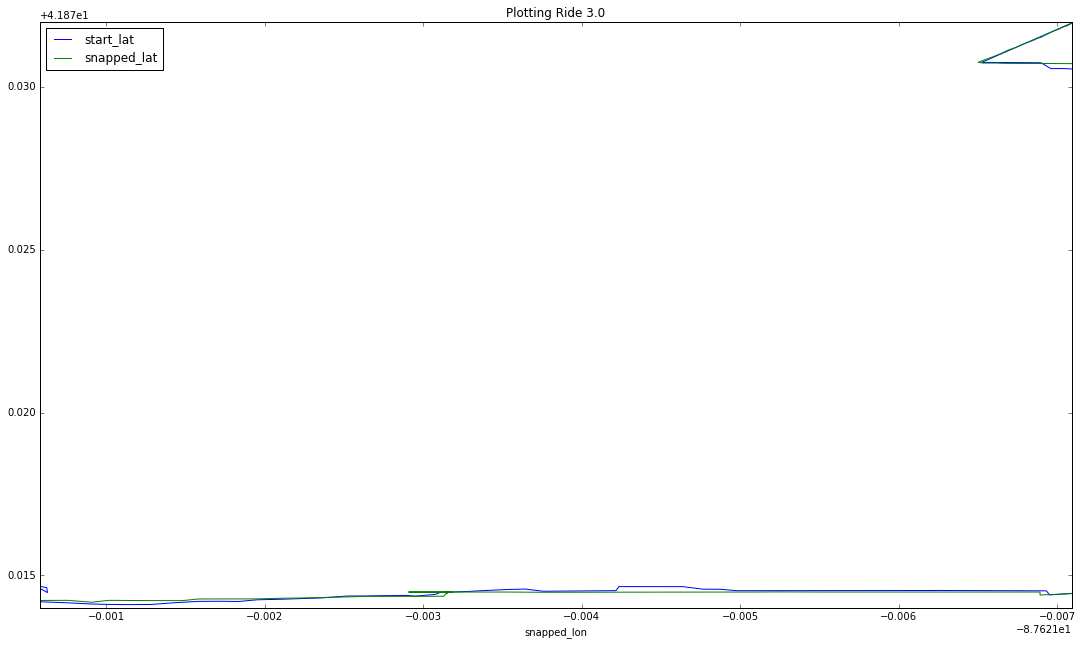

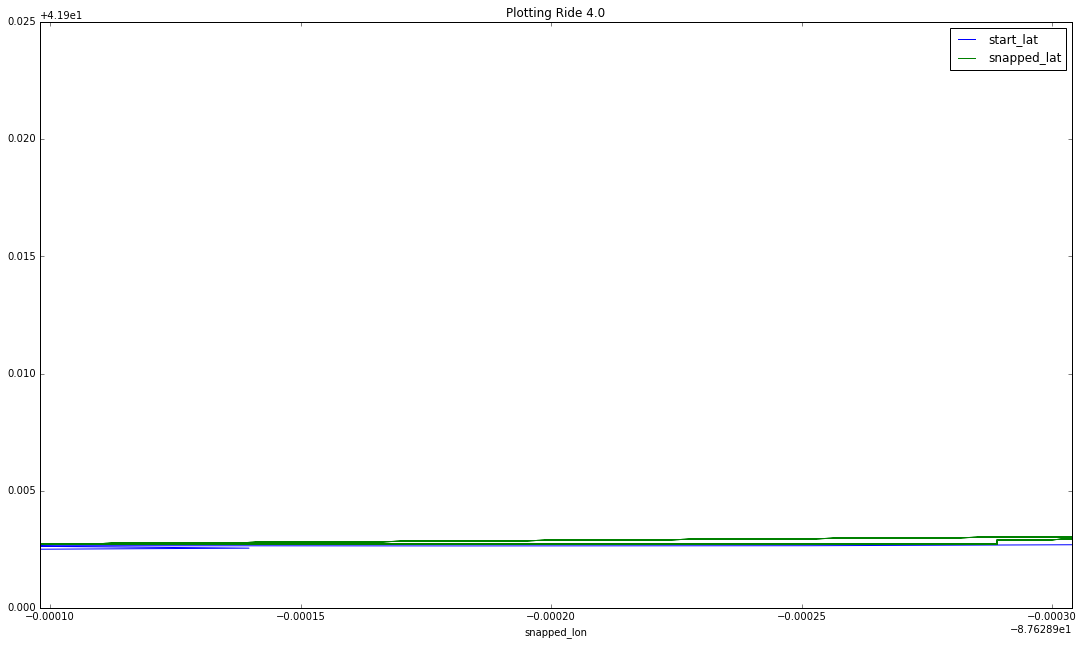

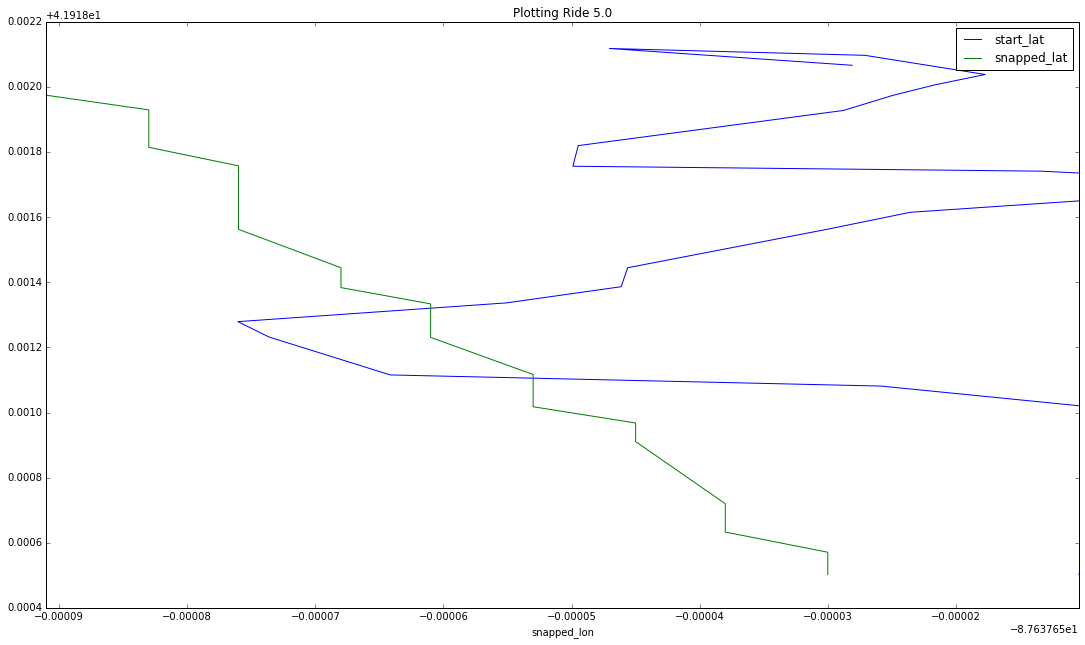

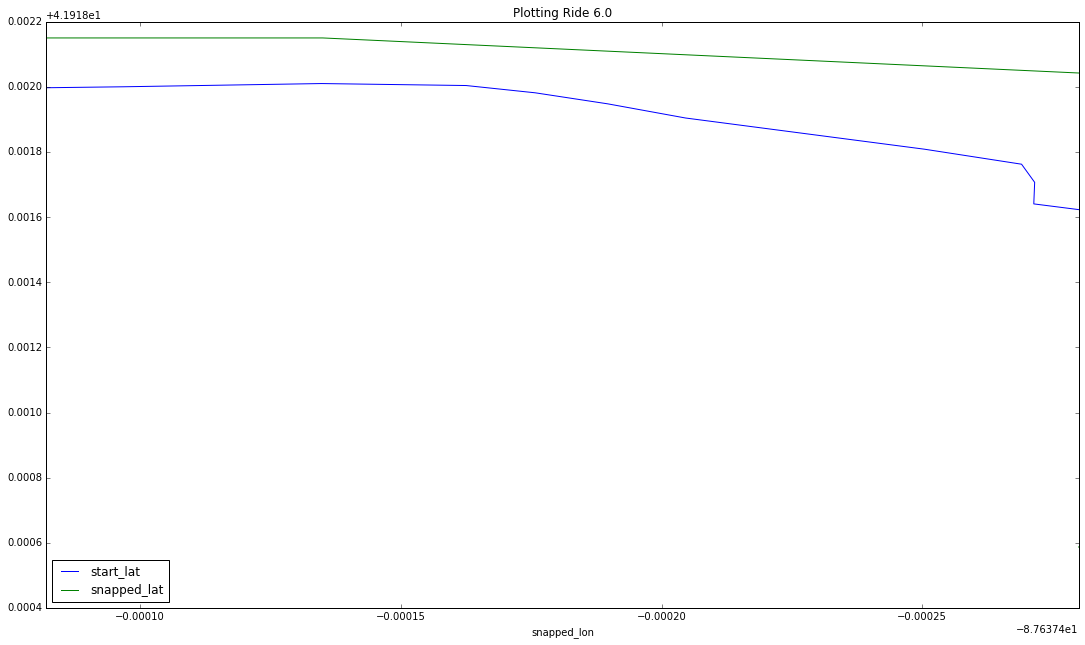

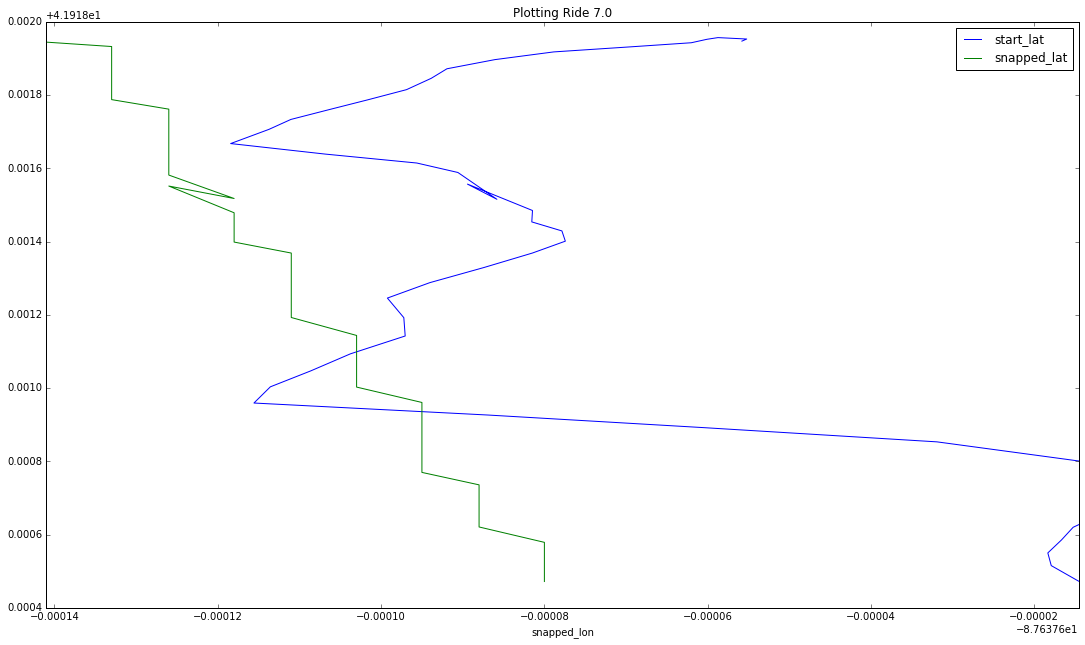

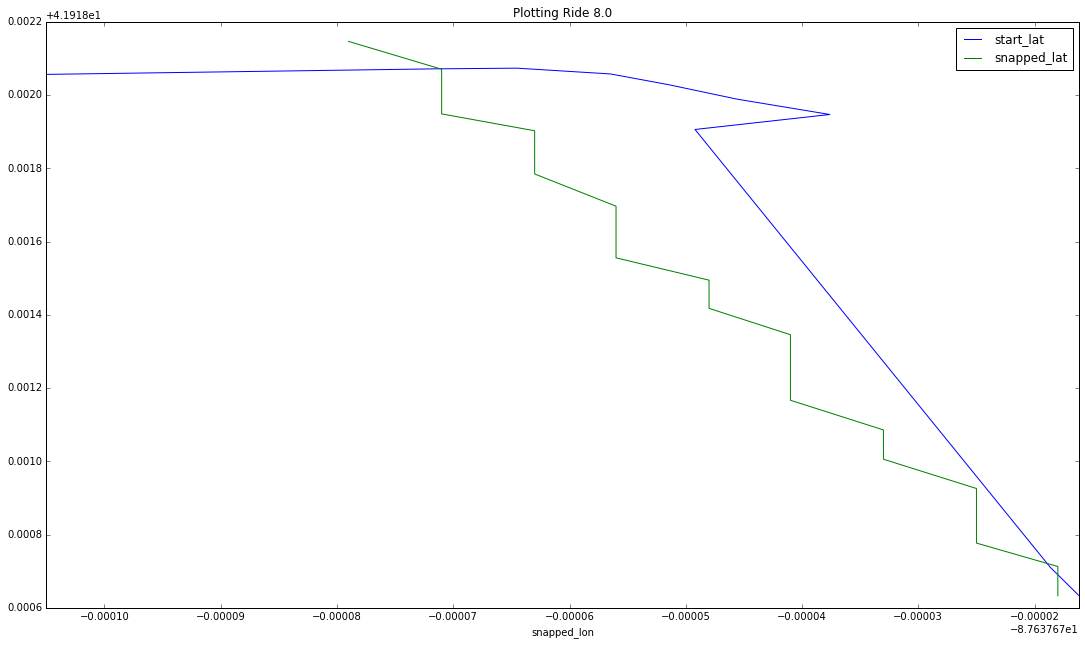

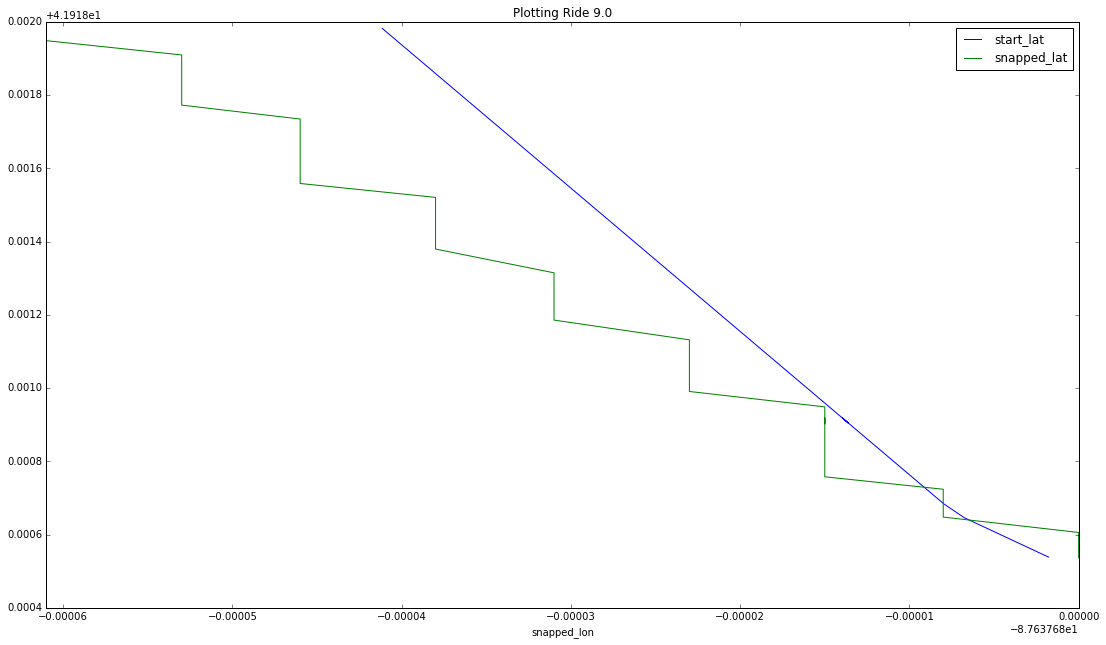

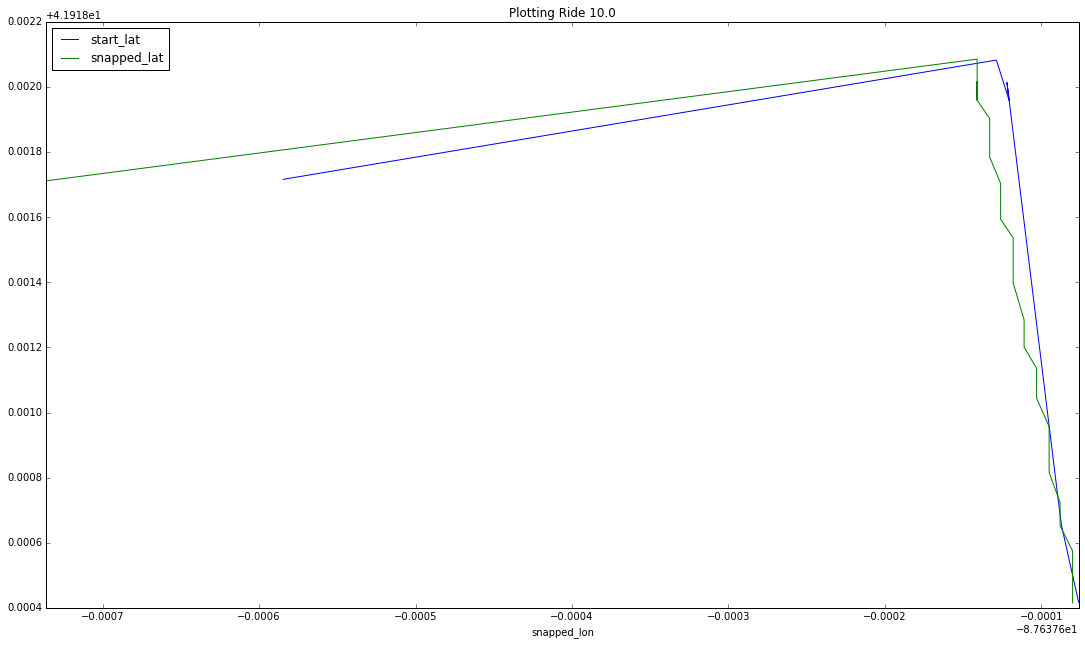

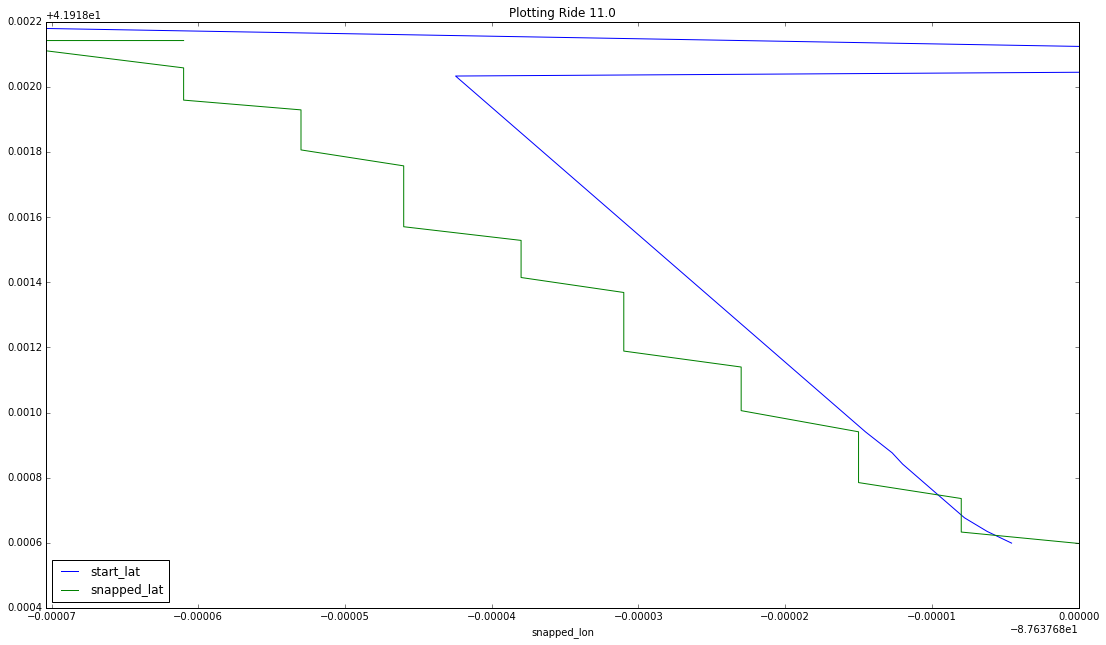

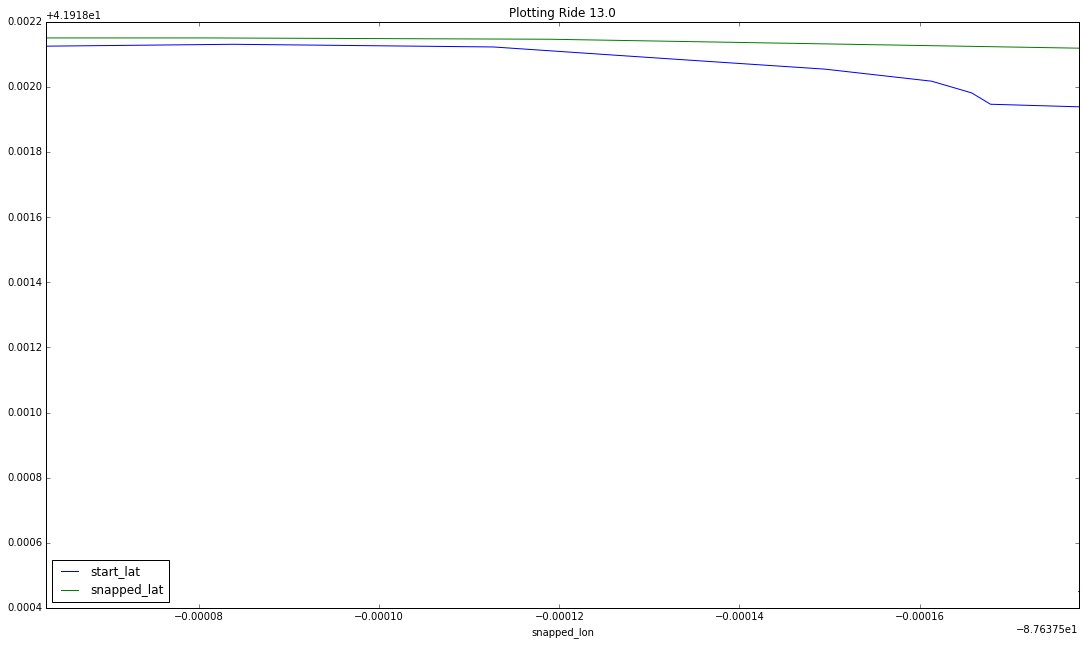

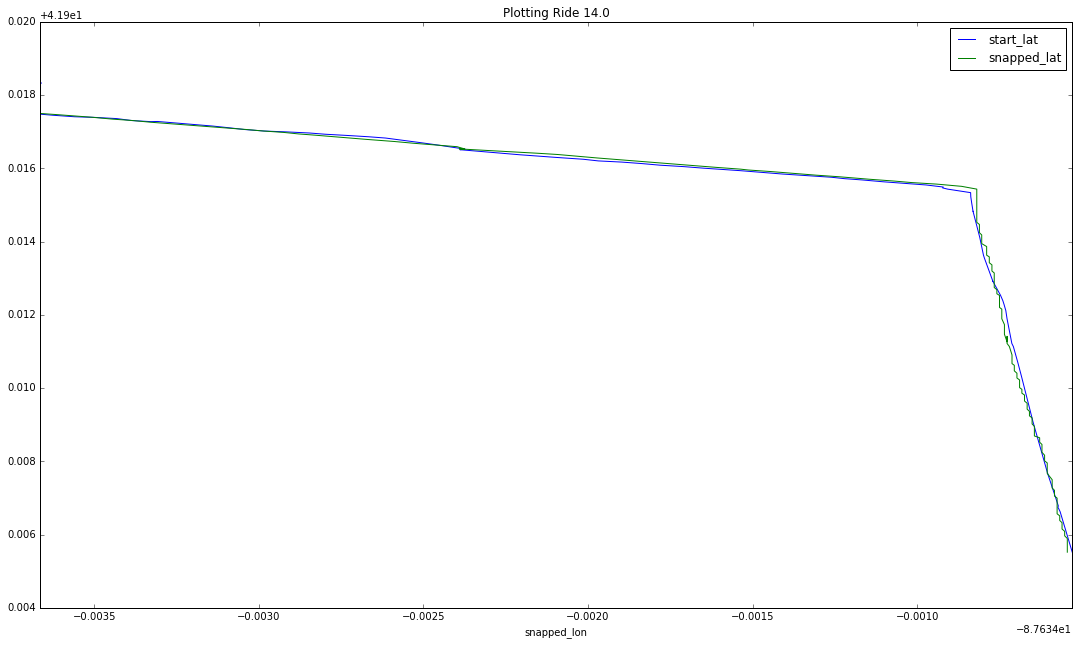

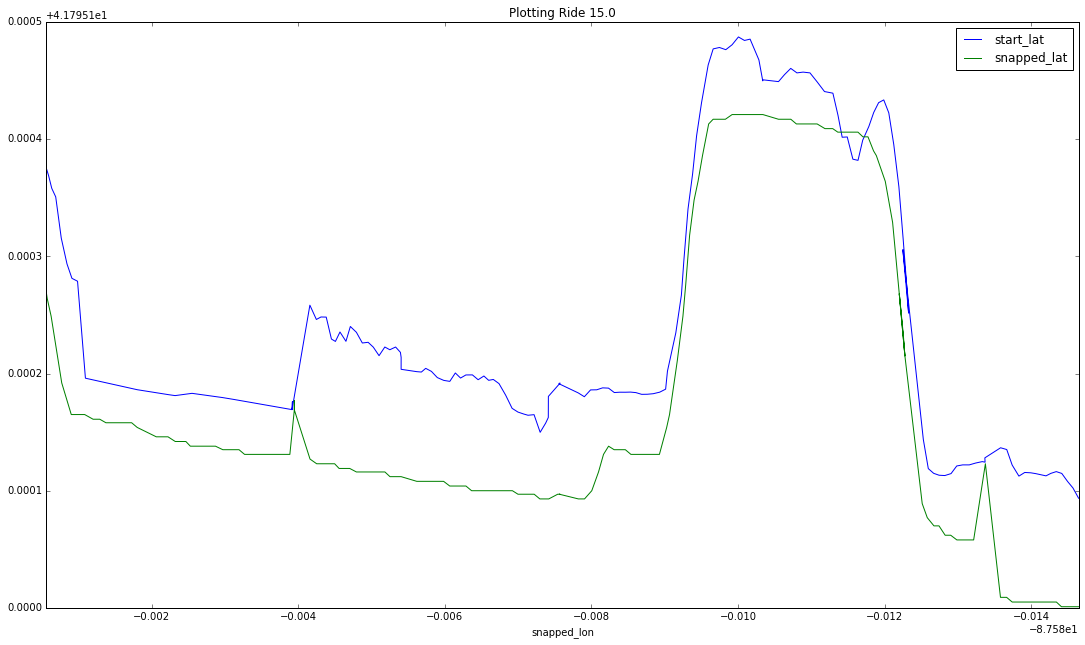

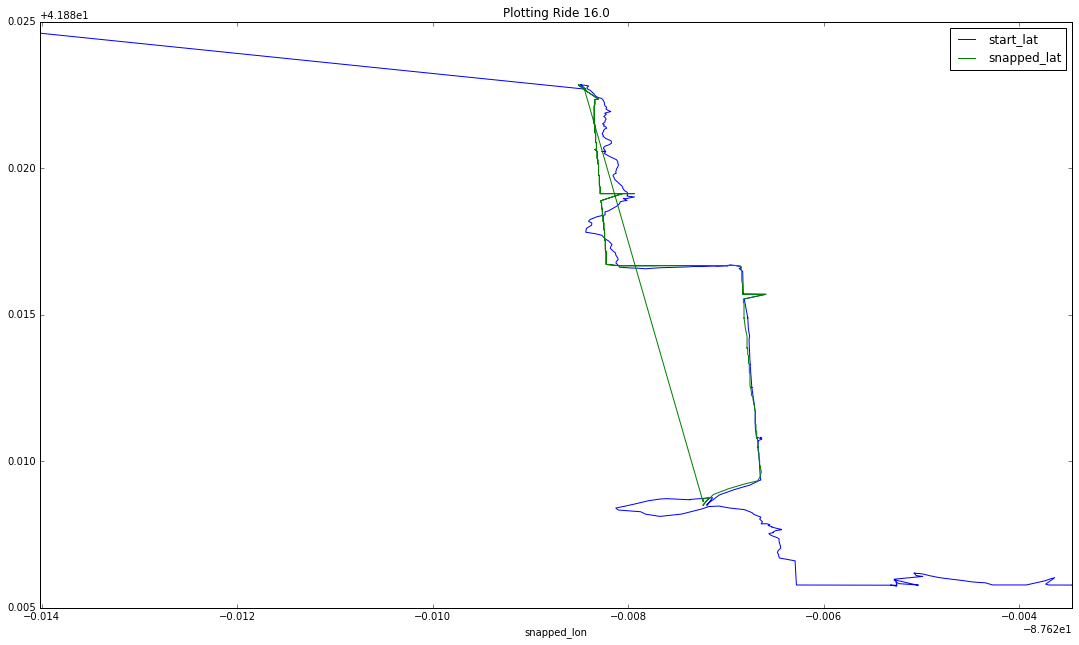

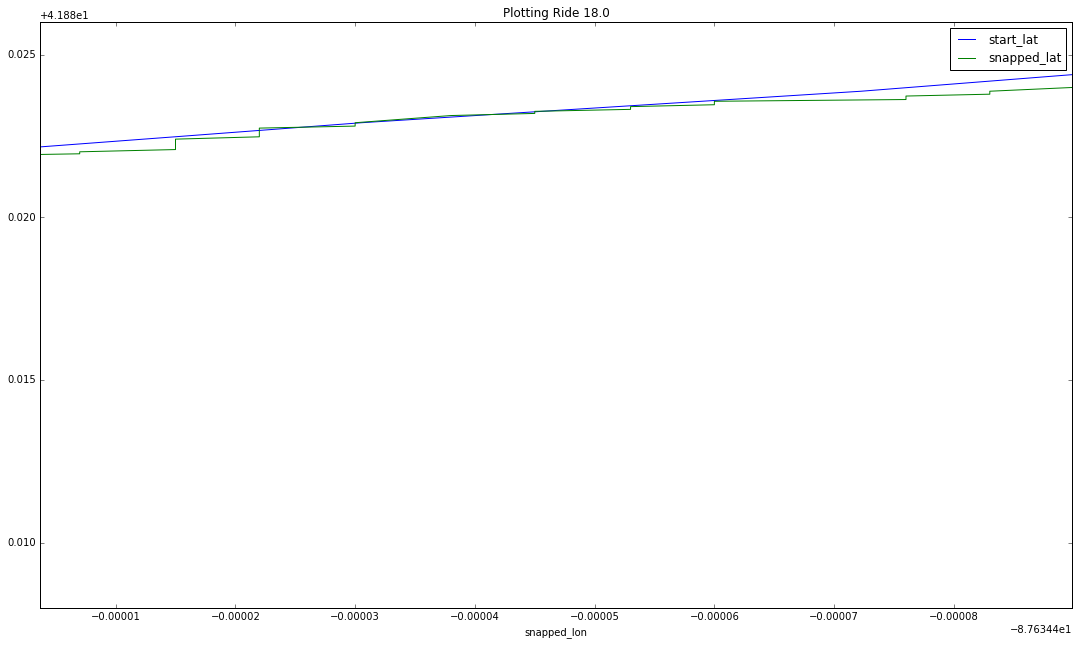

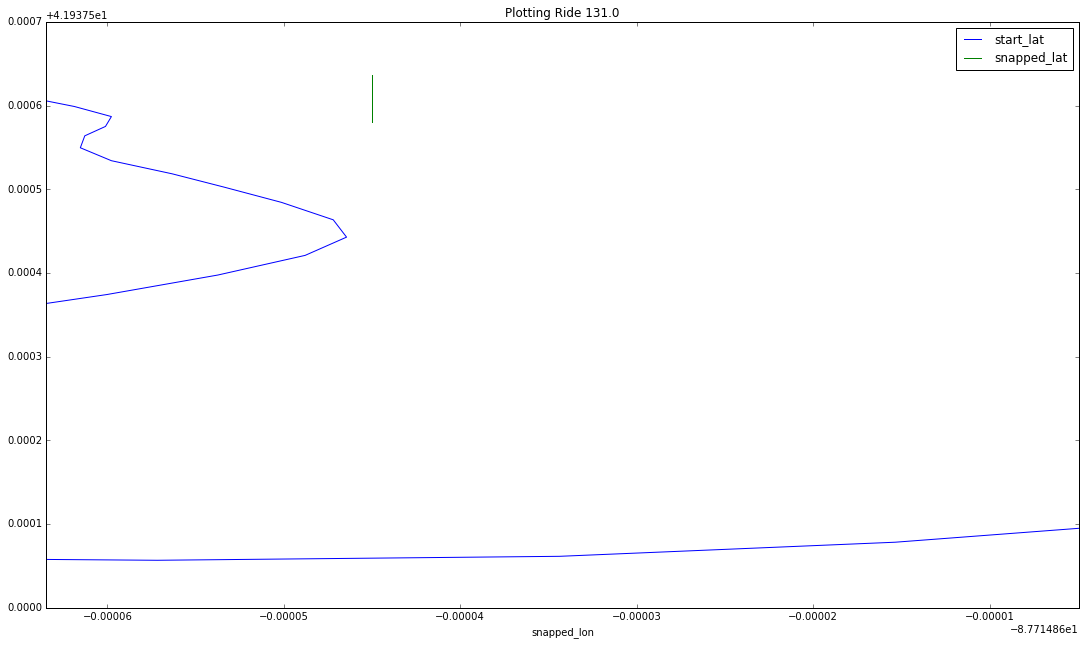

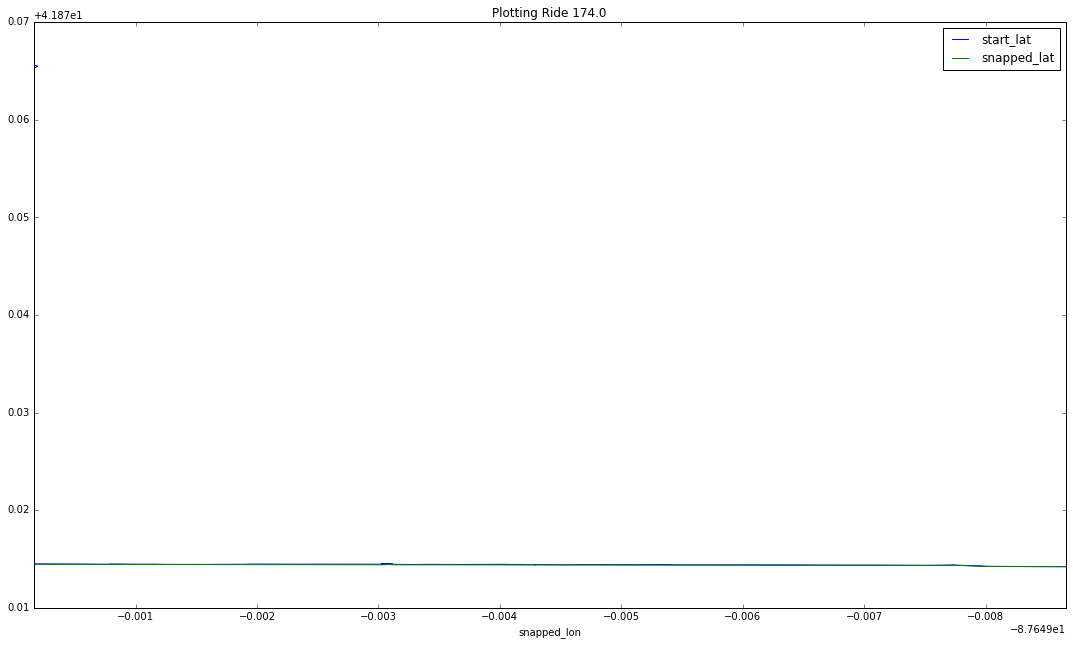

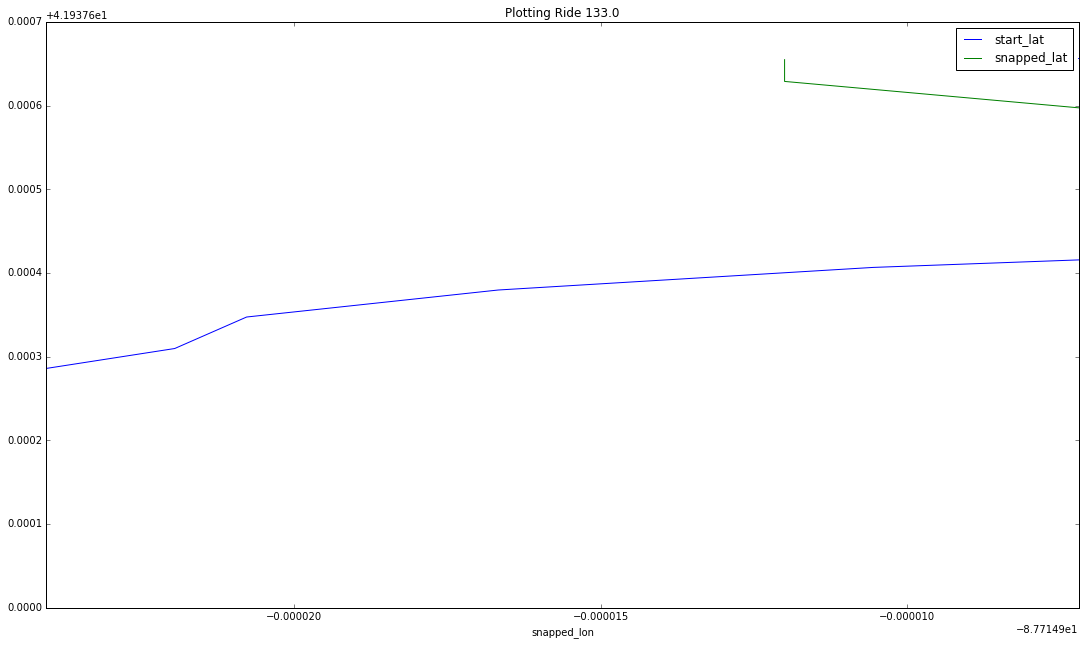

could not snap


/opt/conda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-87.6276552133, right=-87.6276552133
  'left=%s, right=%s') % (left, right))


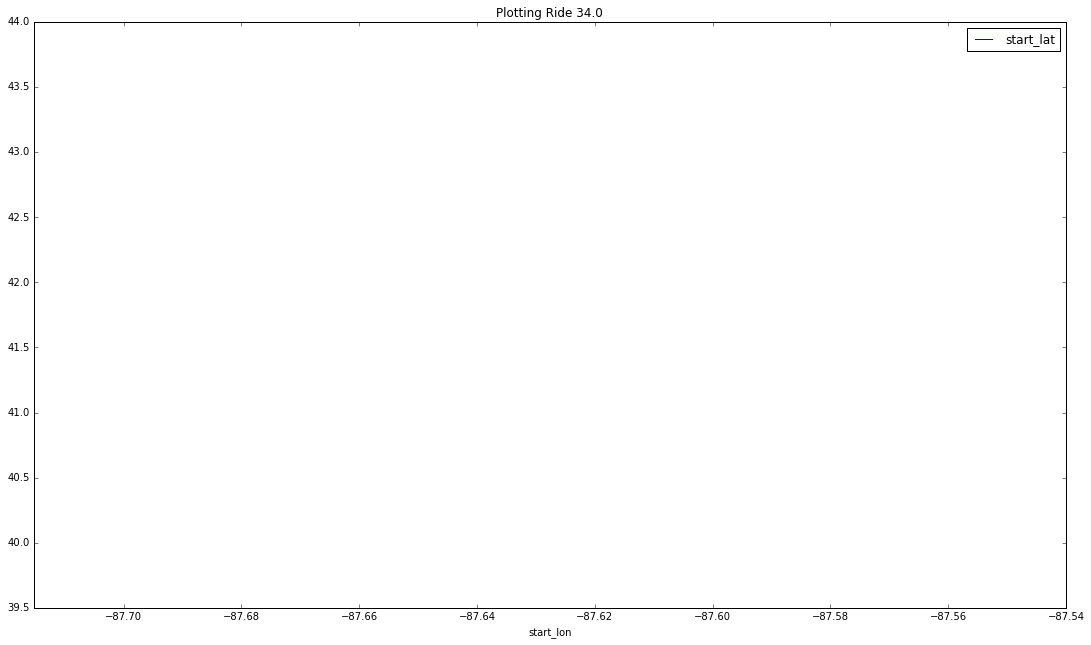

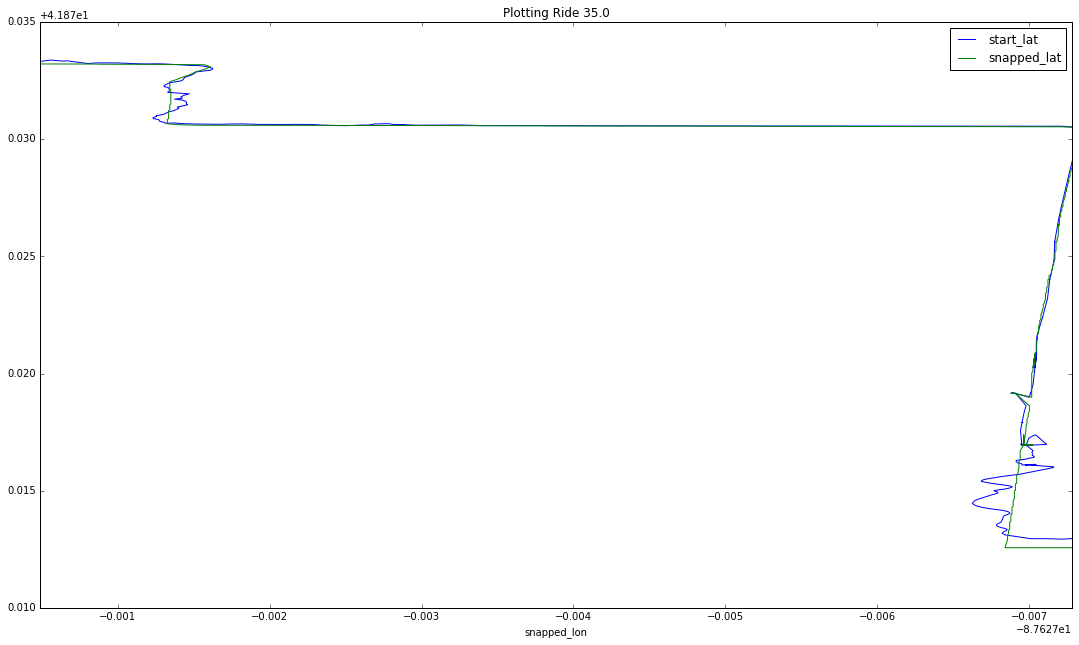

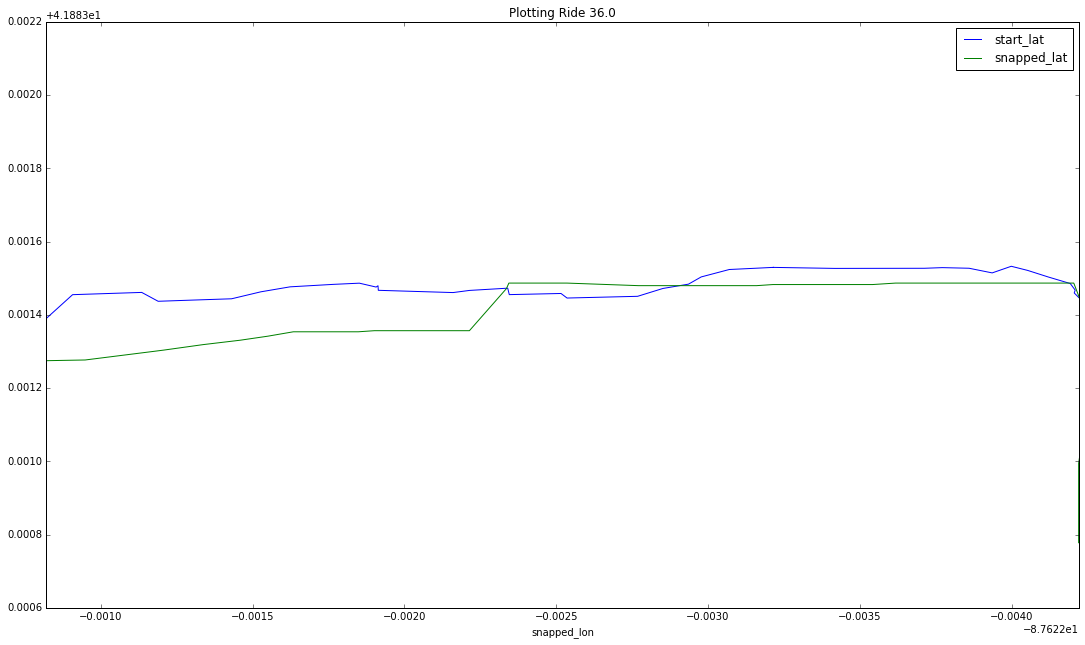

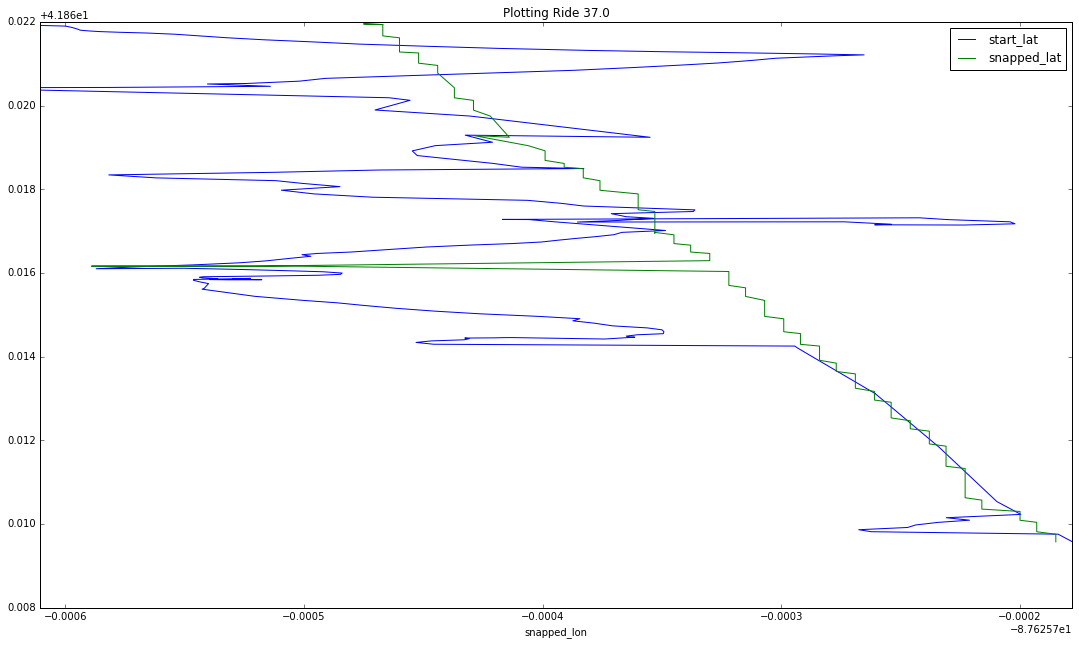

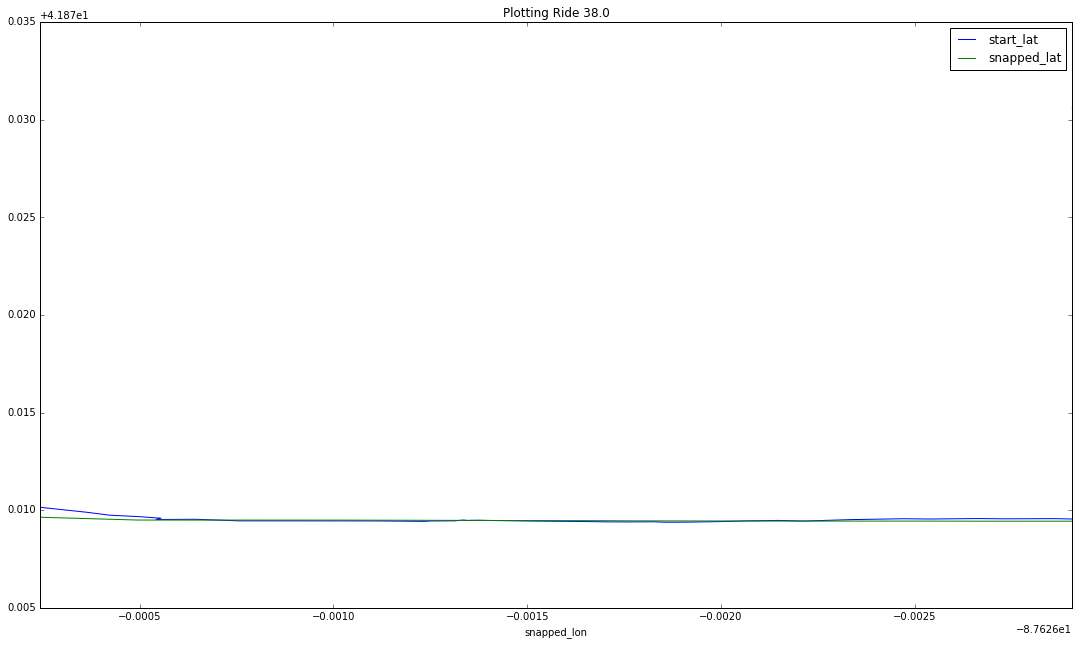

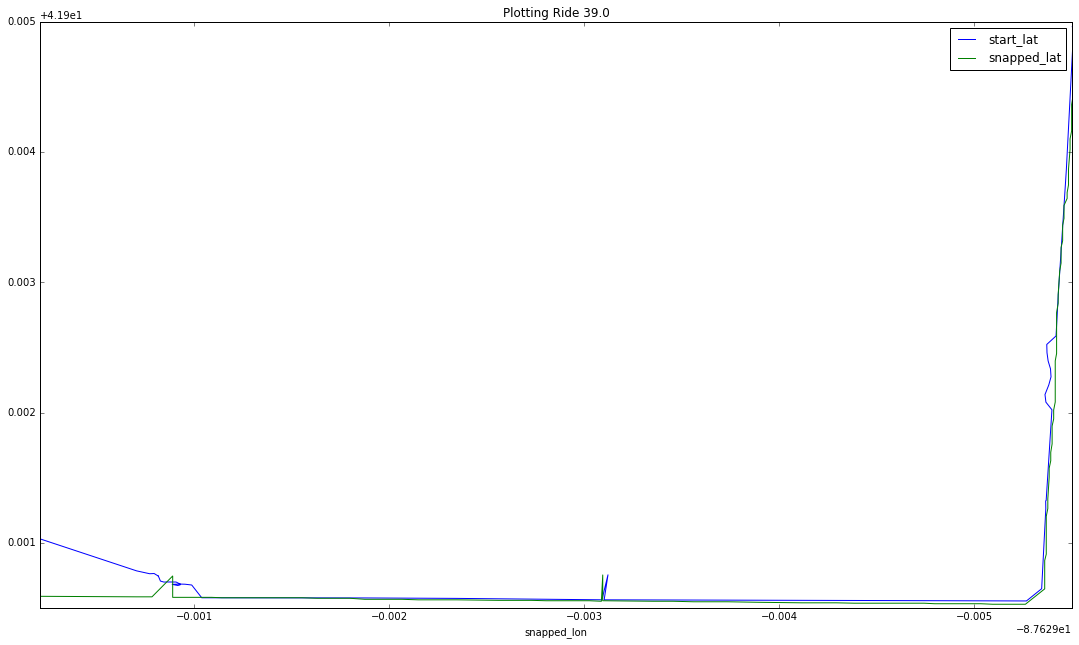

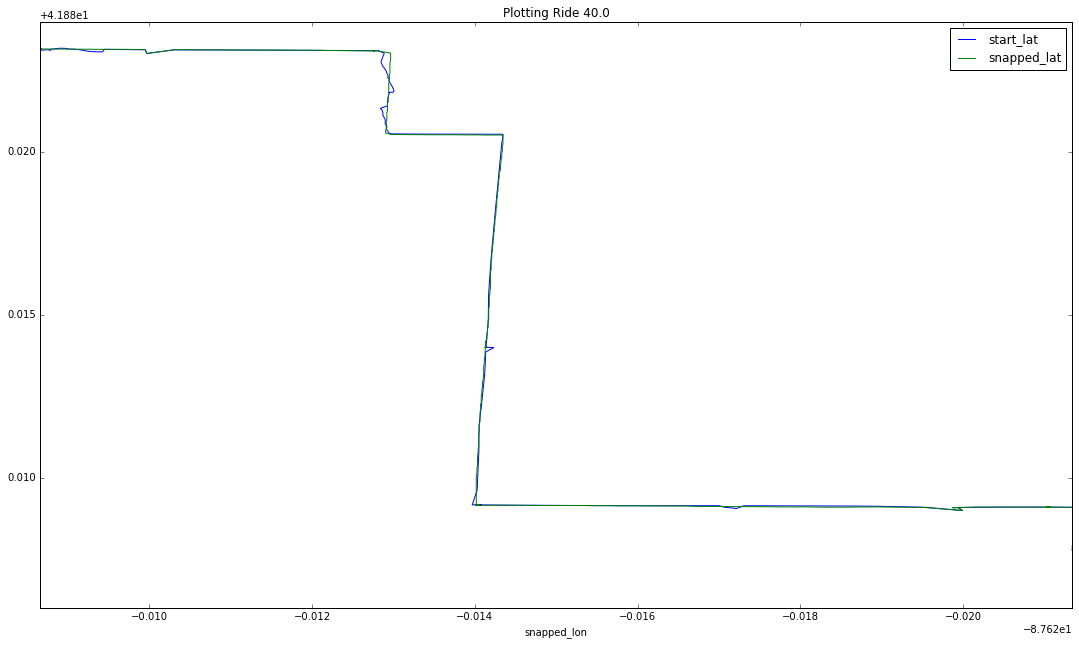

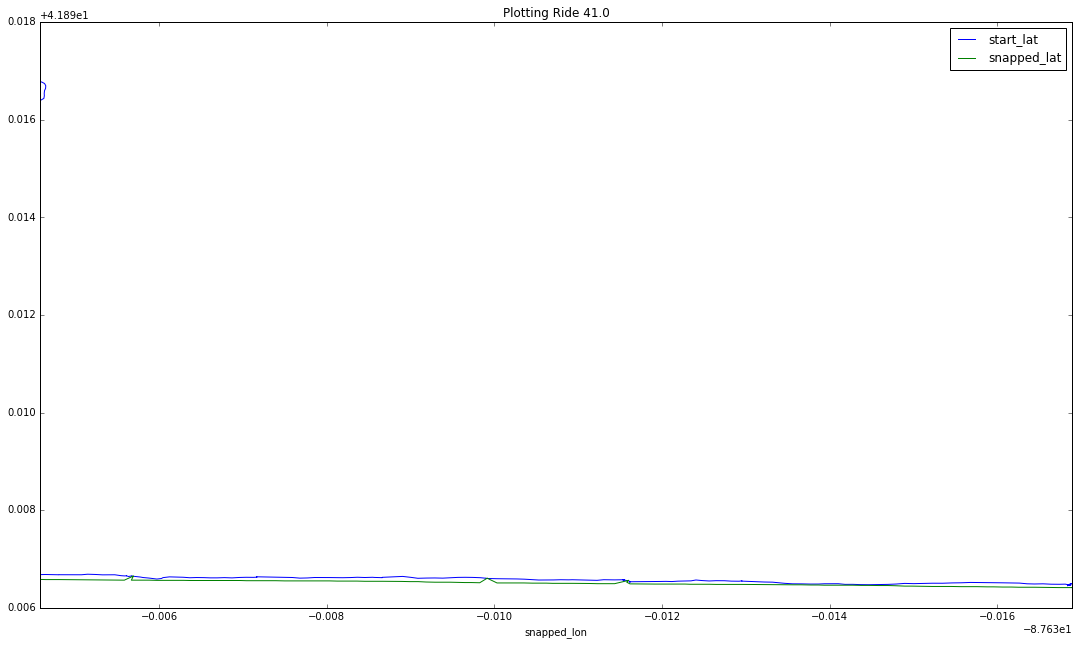

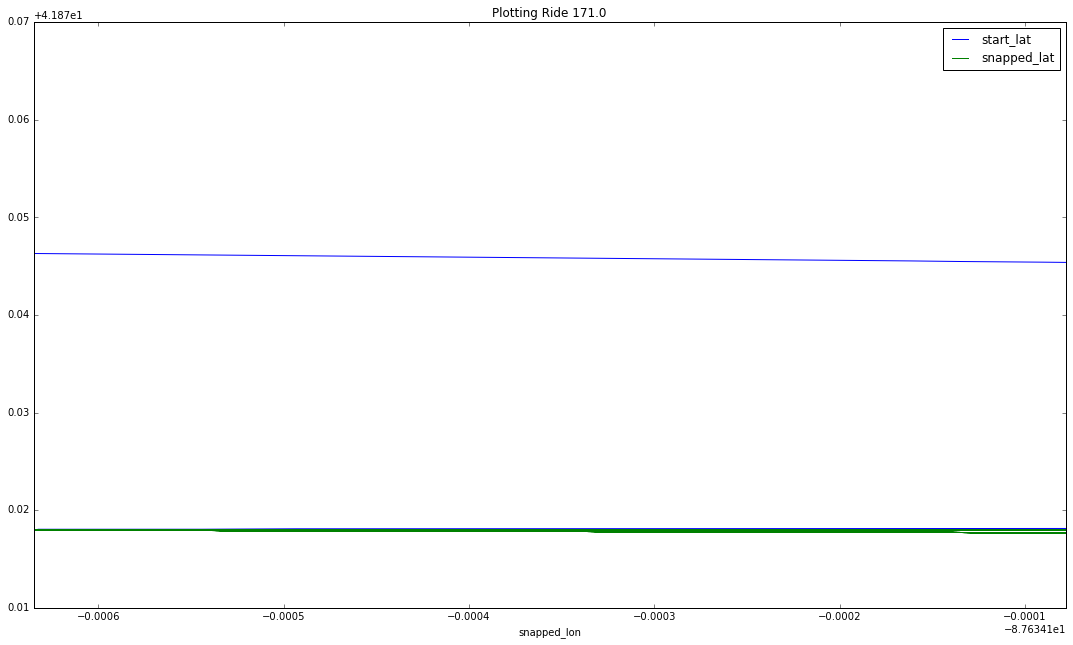

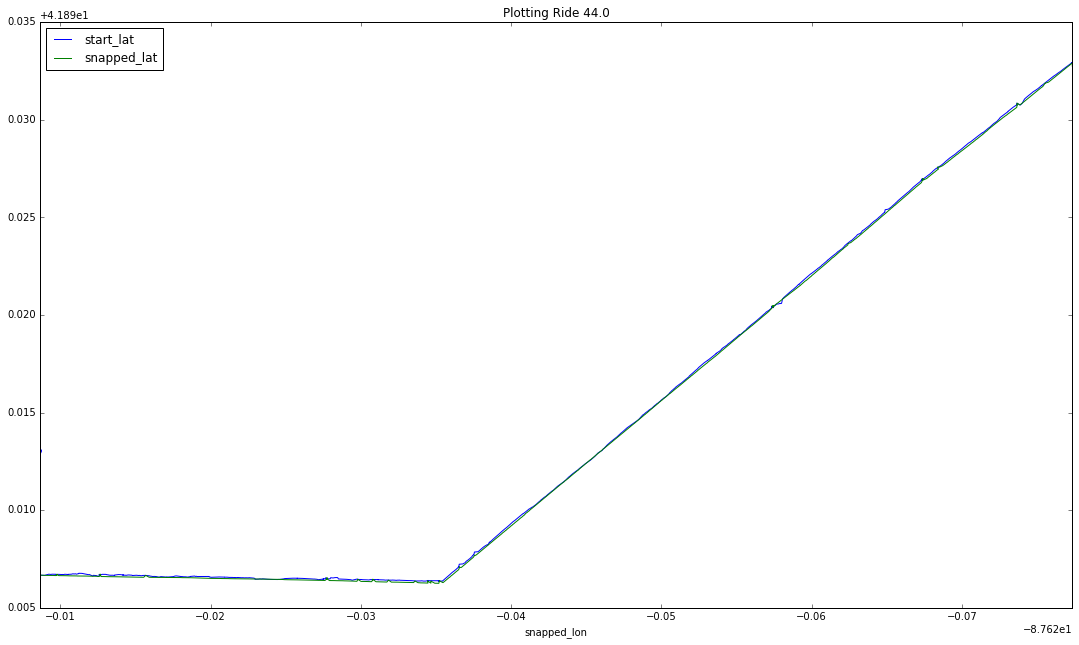

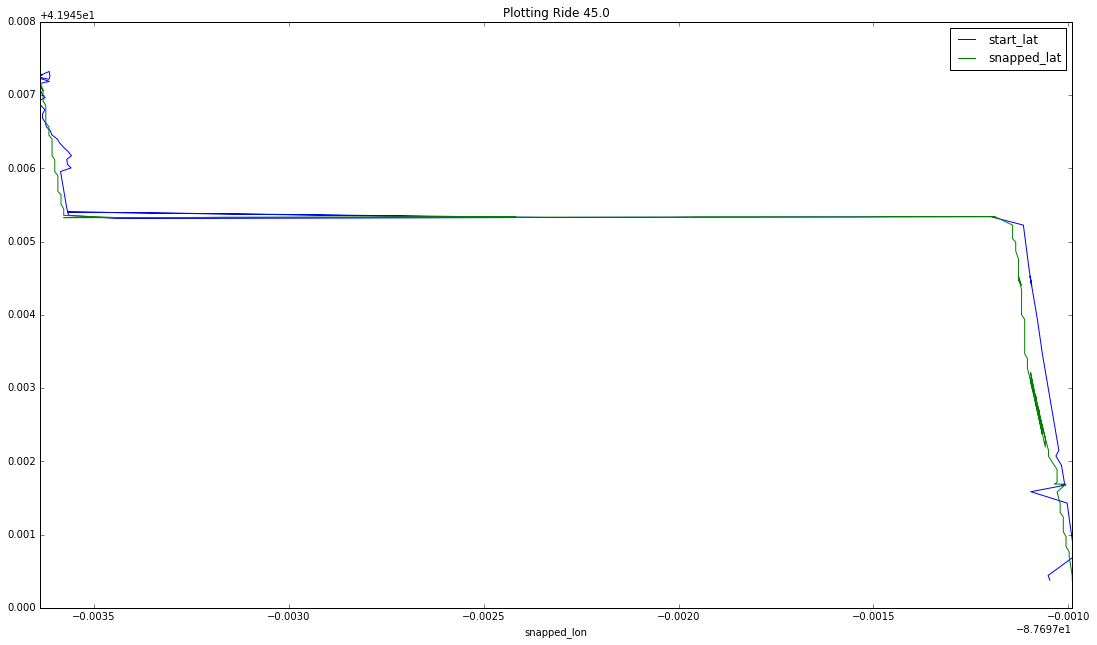

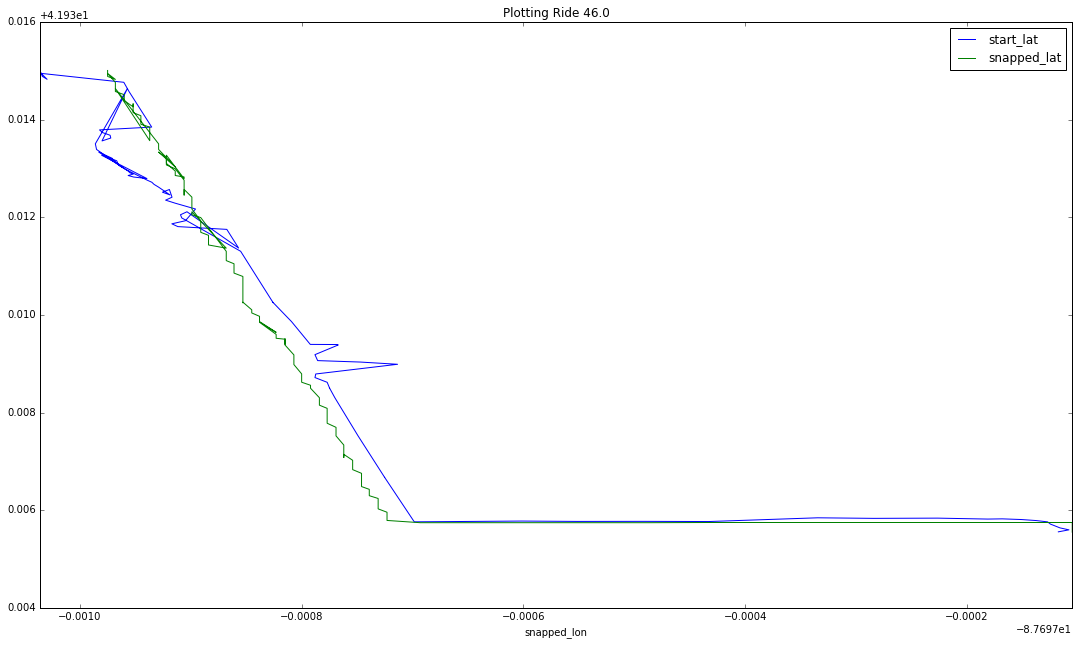

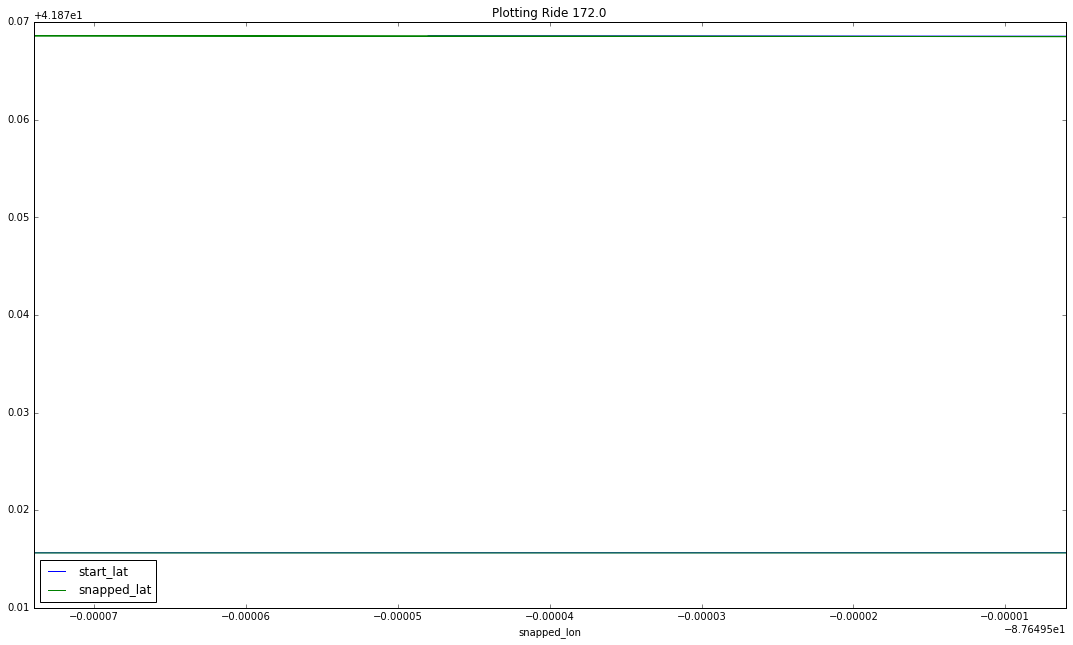

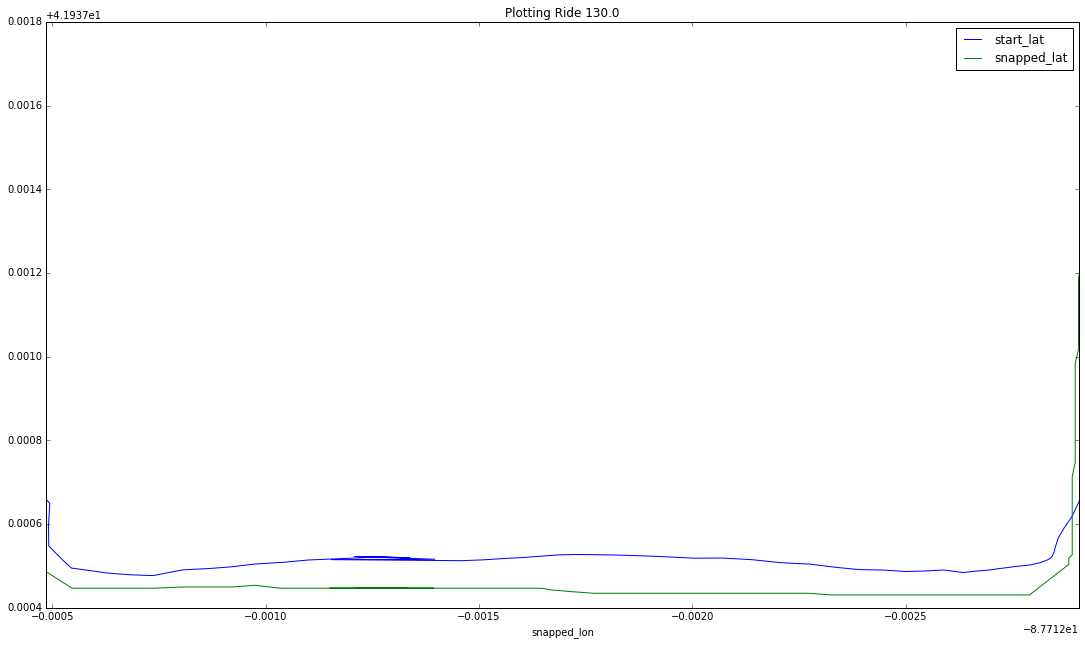

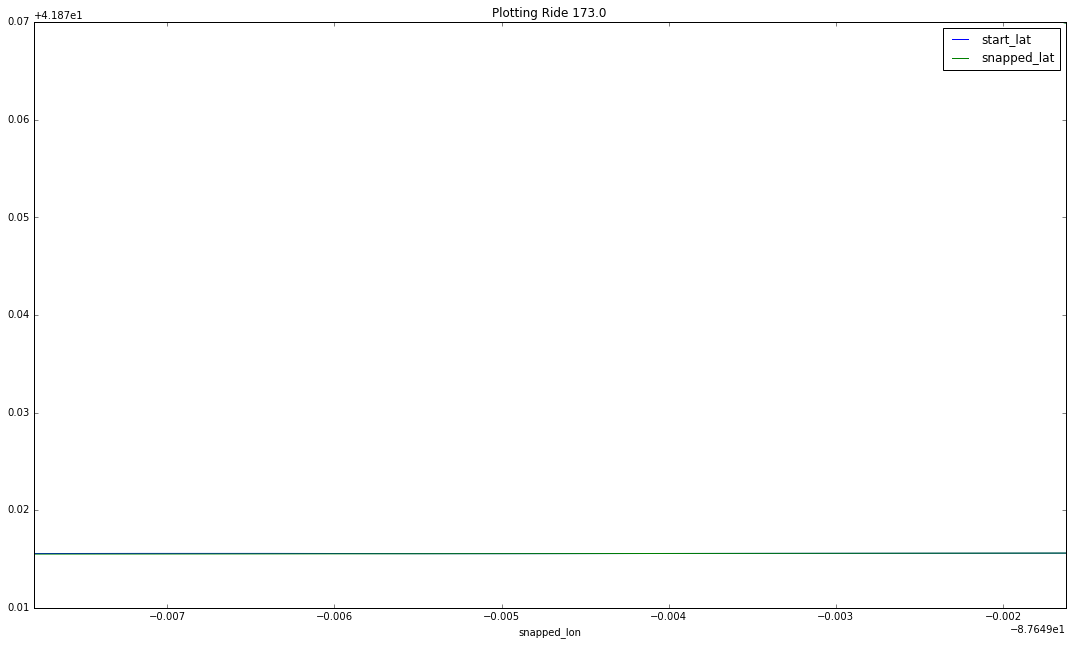

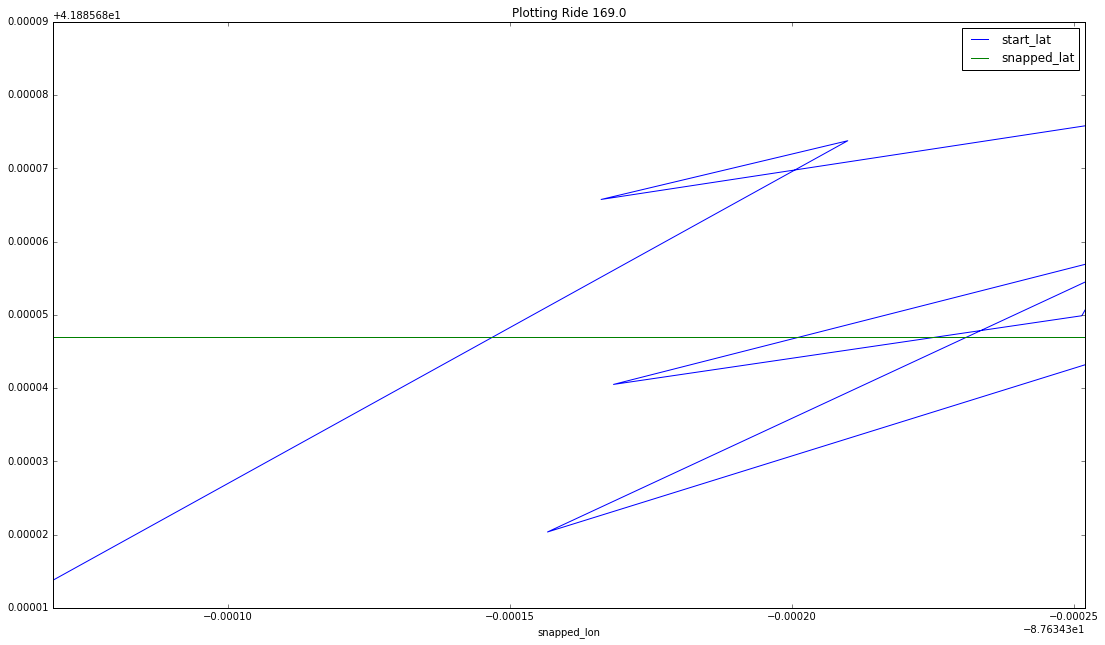

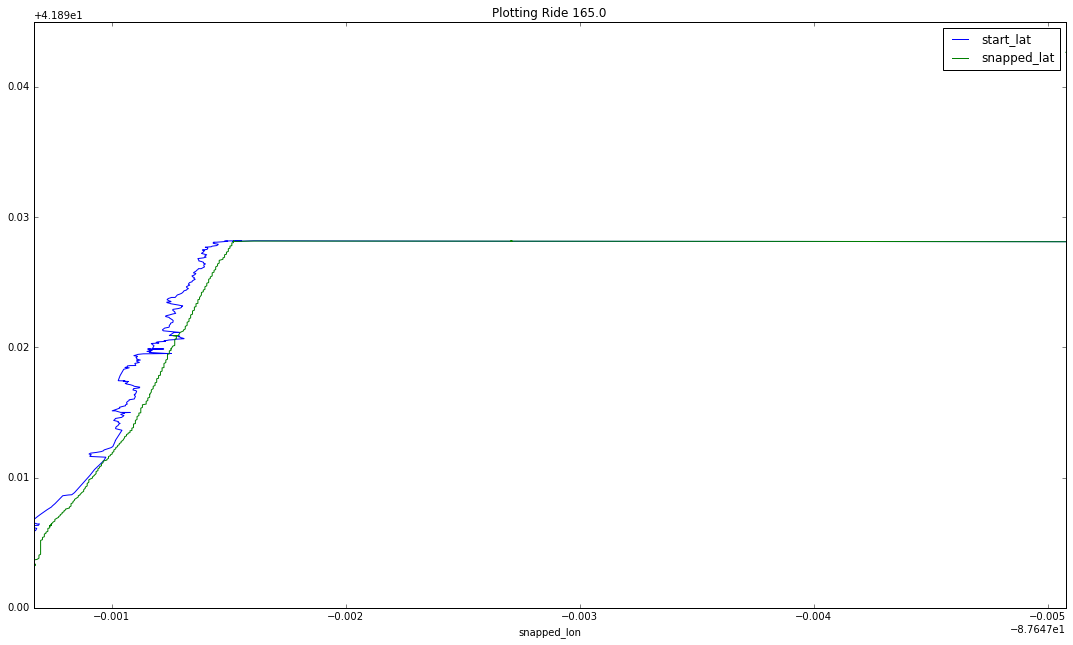

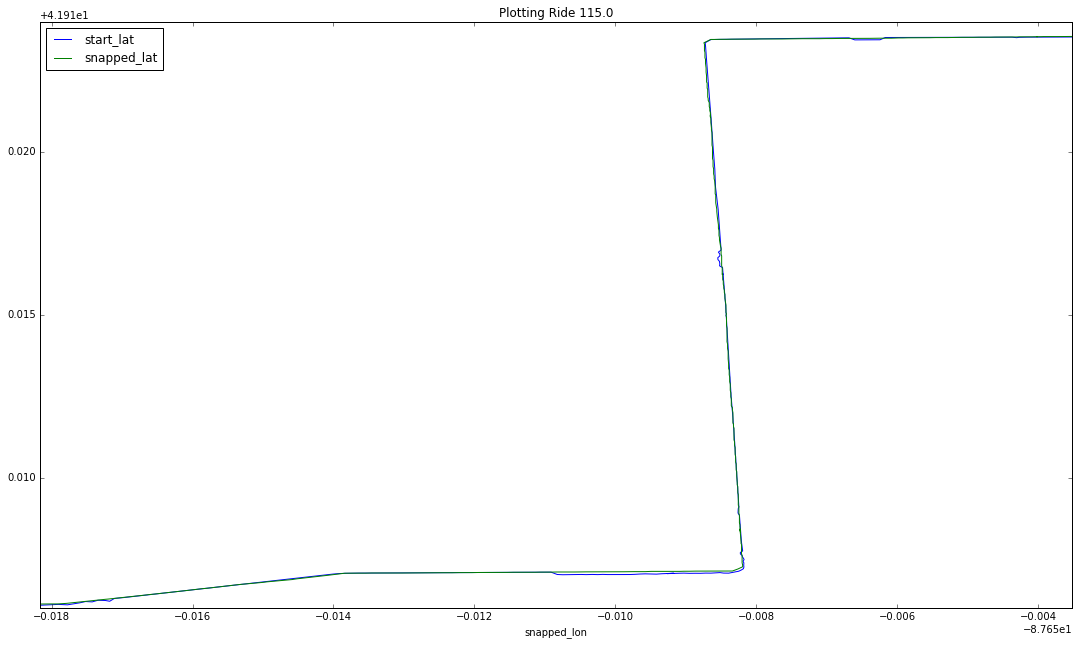

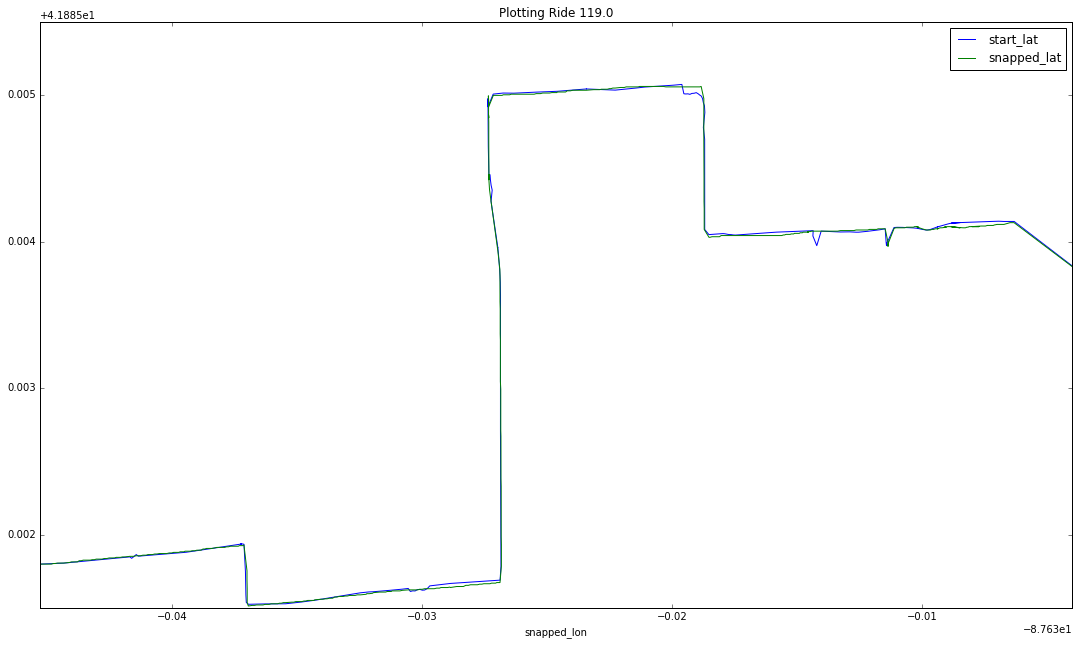

could not snap


/opt/conda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-87.6364372217, right=-87.6364372217
  'left=%s, right=%s') % (left, right))


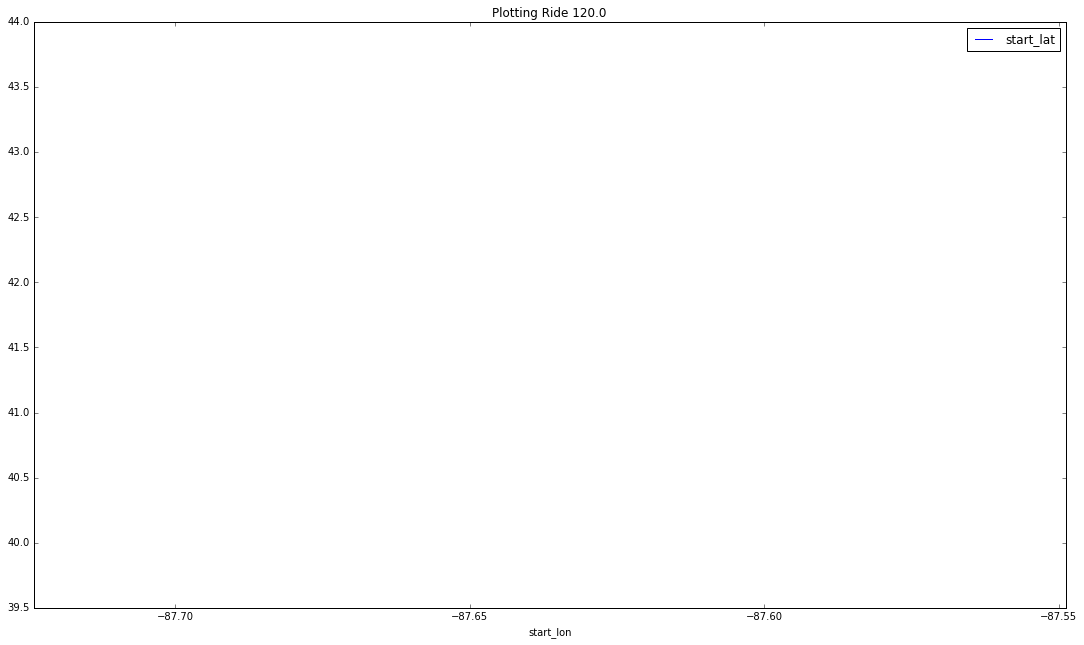

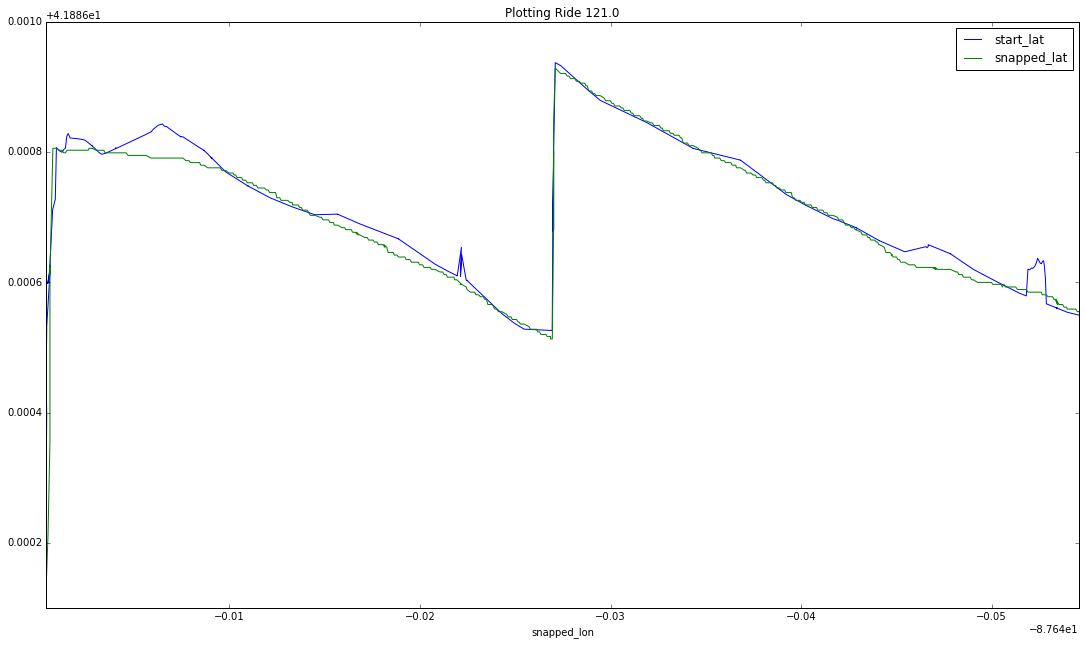

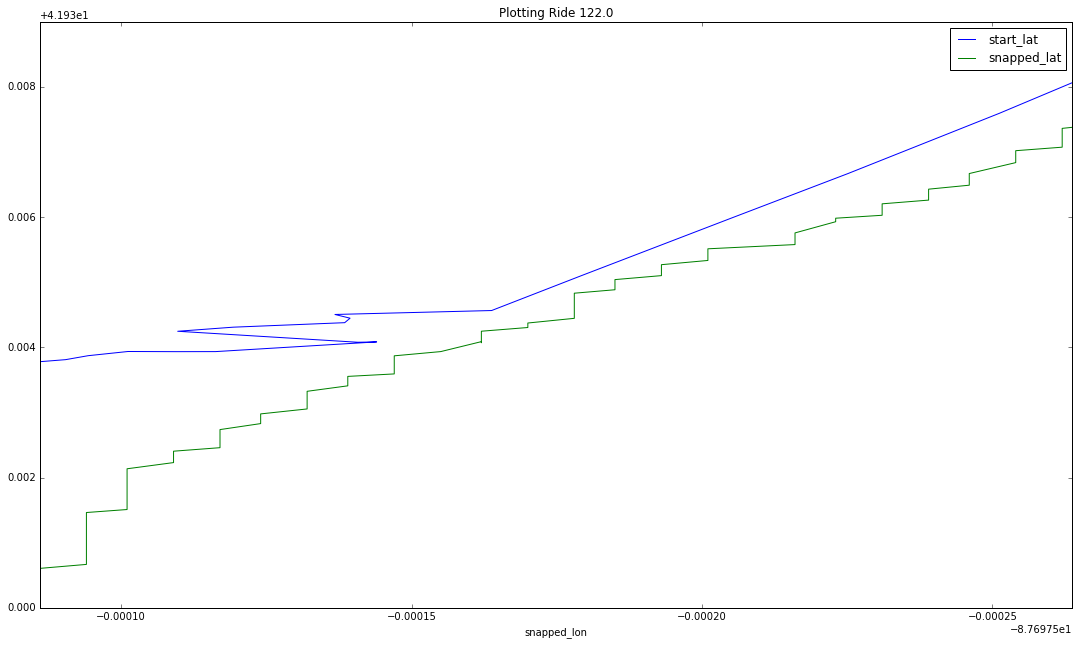

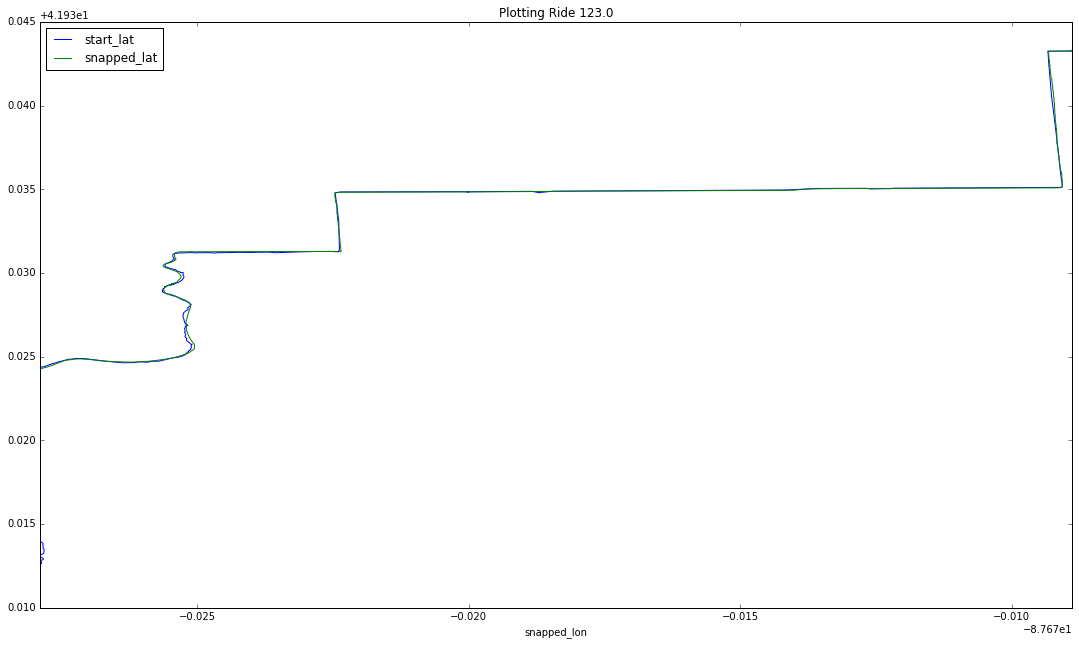

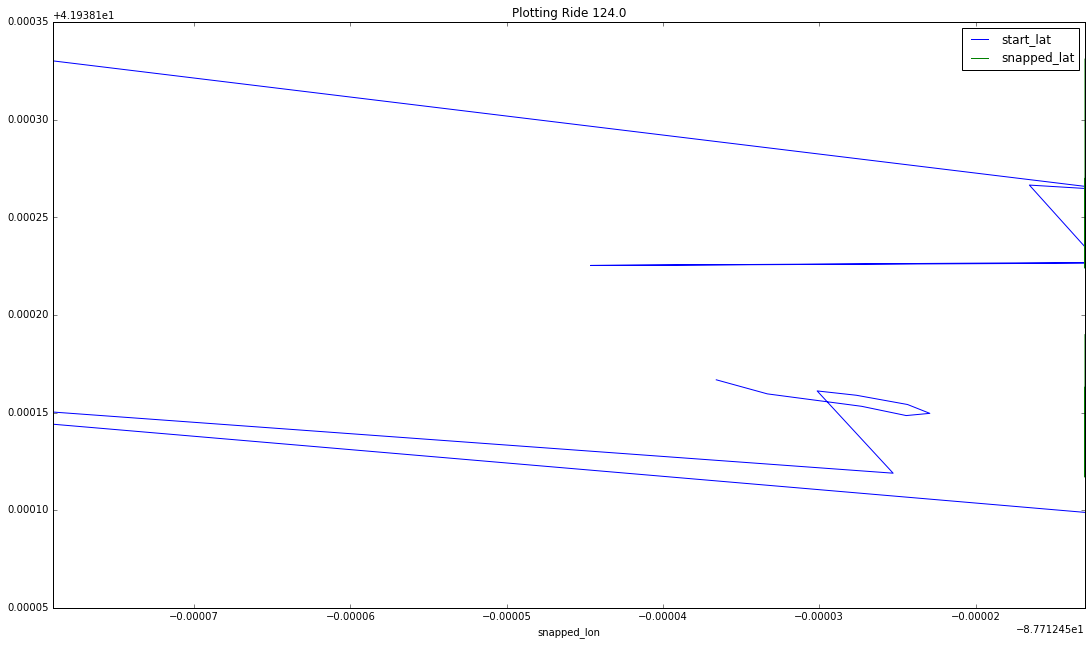

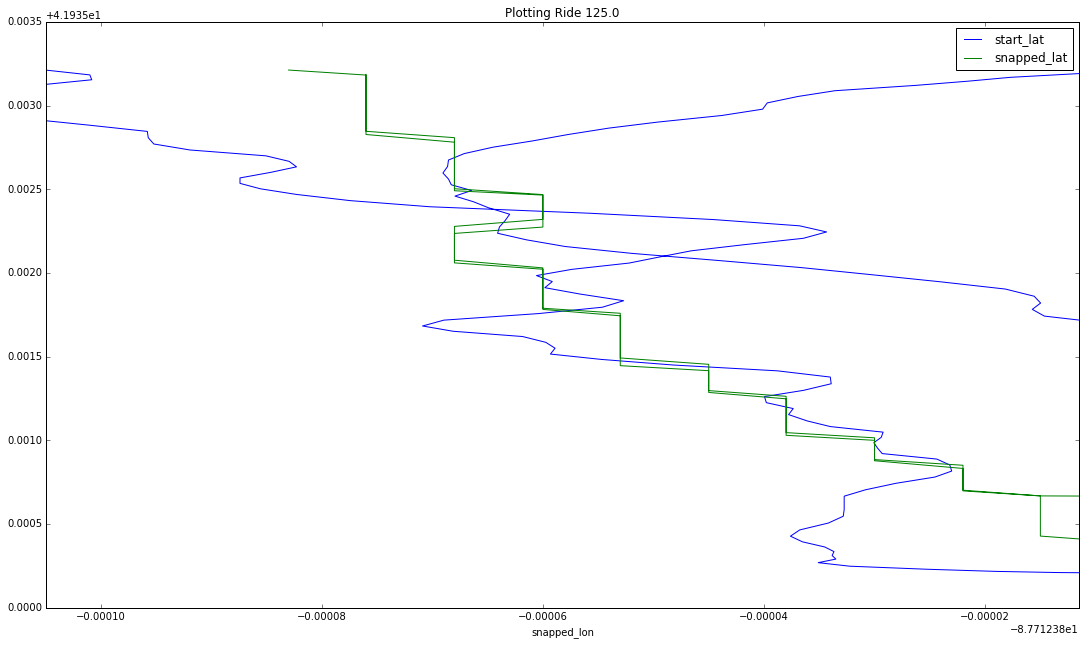

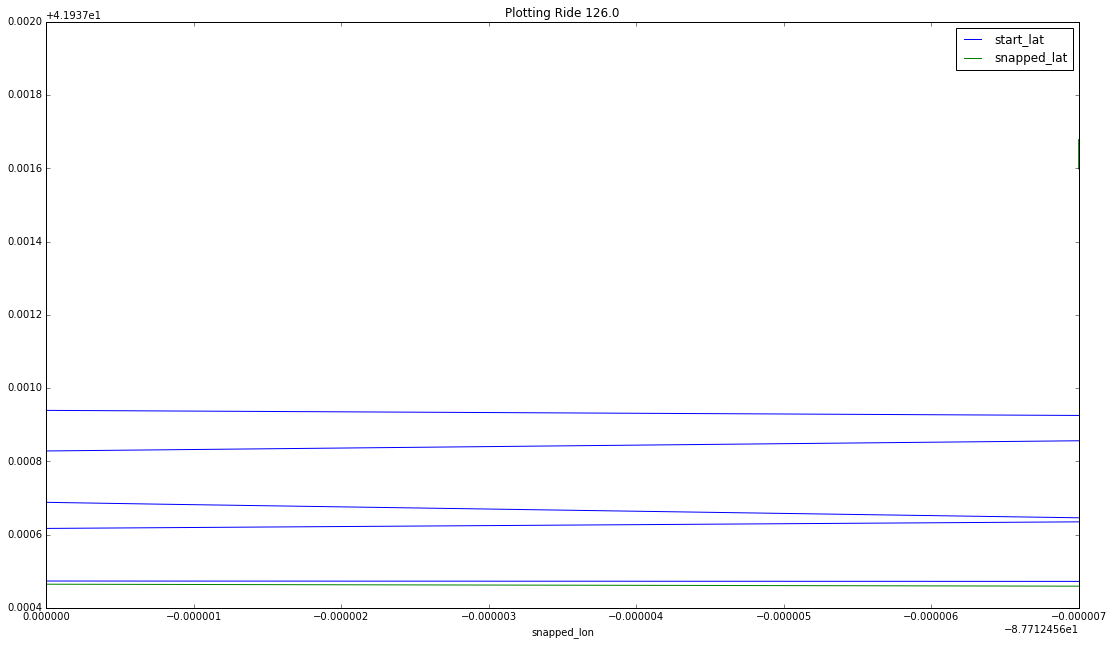

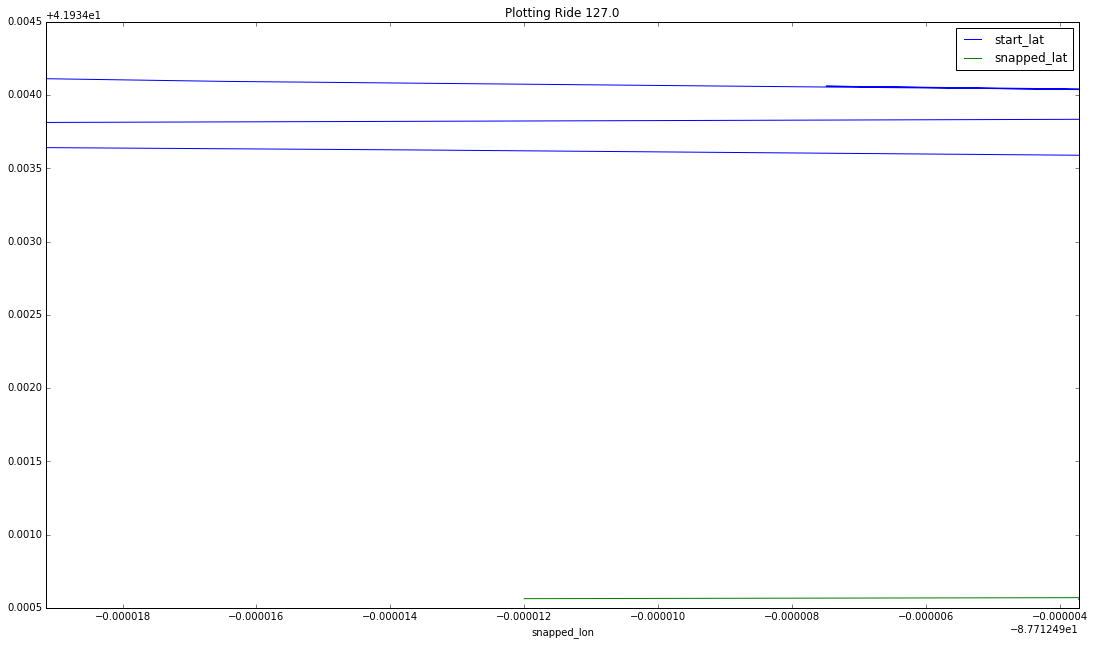

In [19]:
all_snapped_points = []
readings['snapped_lat'] = np.NaN
readings['snapped_lon'] = np.NaN
for ride_id in chi_rides:
    if pd.notnull(ride_id):
#         for i, reading in readings.loc[readings['ride_id'] == random_ride_id, :].iterrows():
#             ax = plt.plot([reading['start_lon'], reading['end_lon']], [reading['start_lat'], reading['end_lat']])
        ax = readings.loc[readings['ride_id'] == ride_id, :].plot(x='start_lon', y='start_lat')
        try:
            matched_ride = requests.get(readings_to_match_str(readings.loc[readings['ride_id'] == ride_id,  :])).json() 
            readings.loc[readings['ride_id'] == ride_id, ['snapped_lat', 'snapped_lon']] = matched_ride['matchings'][0]['matched_points']
            readings.loc[readings['ride_id'] == ride_id, :].plot(x='snapped_lon', y='snapped_lat', ax=ax)
        except:
            print('could not snap')
        plt.title('Plotting Ride ' + str(ride_id))
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.show()

In [ ]:
# all_snapped_points = []
# readings['snapped_lat'] = np.NaN
# readings['snapped_lon'] = np.NaN
# for ride_id in chi_rides:
#     if pd.notnull(ride_id):
# #         for i, reading in readings.loc[readings['ride_id'] == random_ride_id, :].iterrows():
# #             ax = plt.plot([reading['start_lon'], reading['end_lon']], [reading['start_lat'], reading['end_lat']])
#         ax = readings.loc[readings['ride_id'] == ride_id, :].plot(x='start_lon', y='start_lat')
#         try:
#             matched_ride = requests.get(readings_to_match_str(readings.loc[readings['ride_id'] == ride_id,  :])).json() 
#             readings.loc[readings['ride_id'] == ride_id, ['snapped_lat', 'snapped_lon']] = matched_ride['matchings'][0]['matched_points']
#             snapped_points =  pd.DataFrame(matched_ride['matchings'][0]['matched_points'], columns=['lat', 'lon'])
#             readings.loc[readings['ride_id'] == 'ride_id', ['snapped_lat', 'snapped_lon']] = matched_ride['matchings'][0]['matched_points']
#             readings.loc[readings['ride_id'] == 'ride_id', 'snapped_lon'] = snapped_points['lon']
#             snapped_points['ride_id'] = ride_id
#             snapped_points['id'] = readings.loc[readings['ride_id'] == ride_id, ['id']]
#             snapped_points.plot(x='lon', y='lat', ax=ax)
#             print('this thing right here')
#             all_snapped_points.append(snapped_points)
#         except:
#             print('could not snap')
#         plt.title('Plotting Ride ' + str(ride_id))
#         fig = plt.gcf()
#         fig.set_size_inches(18.5, 10.5)
#         plt.show()

In [ ]:
good_chi_rides = [i for i in chi_rides if i not in bad_rides]

In [ ]:
# complete_snapped_points = pd.concat(all_snapped_points)

In [ ]:
ax = readings.loc[readings['ride_id'] == 2, :].plot(x='snapped_lon', y='snapped_lat', style='r-')
for ride_id in good_chi_rides:
    print(ride_id)
    try:
#         readings.loc[readings['ride_id'] == ride_id, :].plot(x='start_lon', y='start_lat', ax=ax)
        readings.loc[readings['ride_id'] == ride_id, :].plot(x='snapped_lon', y='snapped_lat', ax=ax, style='b-')
    except:
        print('bad')
ax = readings.loc[readings['ride_id'] == 2, :].plot(x='snapped_lon', y='snapped_lat', style='r-', ax=ax)
fig = plt.gcf()
fig.set_size_inches(36, 36)
plt.show()

In [ ]:
# lat_lons_by_ride = collections.defaultdict(set)
# for index, row in readings.iterrows():
#     lat_lons_by_ride[tuple(row[['snapped_lat', 'snapped_lon']])].add(row['ride_id'])

In [ ]:
# most_common_lat_lons = sorted(lat_lons_by_ride.items(), key=lambda i: len(i[1]), reverse=True)

This shows that we are in fact snapping to the same points across rides.

In [ ]:
total_printed = 0
for item in most_common_lat_lons:
    total_printed += 1
    print item
    if total_printed > 300:
        break

In [20]:
readings['next_snapped_lat'] = np.NaN
readings['next_snapped_lon'] = np.NaN
for ride_id in chi_rides:
    next_lat_lon = (np.NaN, np.NaN)
    for index, row in reversed(list(readings.loc[readings['ride_id'] == ride_id, :].iterrows())):
        readings.loc[index, ['next_snapped_lat', 'next_snapped_lon']] = next_lat_lon
        if (row['snapped_lat'], row['snapped_lon']) != next_lat_lon:
            next_lat_lon = (row['snapped_lat'], row['snapped_lon'])

In [25]:
clean_chi_readings = readings.loc[[ride_id in chi_rides for ride_id in readings['ride_id']], :]

In [29]:
clean_chi_readings.to_csv(data_munging.data_dir'clean_chi_readings.csv')

In [35]:
road_bumpiness = collections.defaultdict(list)
for index, reading in readings.iterrows():
    if reading['gps_mph'] < 30 and reading['gps_mph'] > 3:
        osm_segment = [(reading['snapped_lat'], reading['snapped_lon']),
                      (reading['next_snapped_lat'], reading['next_snapped_lon'])]
        osm_segment = sorted(osm_segment)
        if all([lat_lon != (np.NaN, np.NaN) for lat_lon in osm_segment]):
            road_bumpiness[tuple(osm_segment)].append(reading['abs_mean_over_speed'])

KeyboardInterrupt: 

In [ ]:
# sorted_road_bumpiness = sorted(road_bumpiness.items(), key=lambda i: len(i[1]), reverse=True)

In [ ]:
agg_road_bumpiness = dict((osm_segment, np.mean(road_bumpiness[osm_segment])) for osm_segment in road_bumpiness)

In [ ]:
agg_path = data_munging.data_dir + 'agg_road_bumpiness.txt'

In [ ]:
with open(agg_path, 'w') as f:
    f.write(str(agg_road_bumpiness))

In [31]:
with open(agg_path, 'r') as f:
    agg_road_bumpiness = f.read()

In [32]:
agg_road_bumpiness = eval(agg_road_bumpiness)

In [33]:
def filter_out_na_from_osm_segments(osm_segment):
    return np.NaN in osm_segment[0] or np.NaN in osm_segment[1]

In [34]:
agg_road_bumpiness = dict((osm_segment, agg_road_bumpiness[osm_segment]) for osm_segment in agg_road_bumpiness if not filter_out_na_from_osm_segments(osm_segment))

In [ ]:
# This is where we filter out all osm segments that are too long

In [72]:
def find_seg_dist(lat_lon):
    return data_munging.calc_dist(lat_lon[0][1], lat_lon[0][0], lat_lon[1][1], lat_lon[1][0])

In [42]:
seg_dist = []
for lat_lon in agg_road_bumpiness:
    seg_dist.append(data_munging.calc_dist(lat_lon[0][1], lat_lon[0][0], lat_lon[1][1], lat_lon[1][0]))

In [74]:
for lat_lon in agg_road_bumpiness:
    if data_munging.calc_dist(lat_lon[0][1], lat_lon[0][0], lat_lon[1][1], lat_lon[1][0]) > 200:
        print(lat_lon)

((41.883041, -87.658775), (41.938583, -87.649574))
((41.888622, -87.627235), (41.902695, -87.628448))


(array([  1.19720000e+04,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    0.        ,   621.61035327,  1243.22070654,  1864.8310598 ,
         2486.44141307,  3108.05176634,  3729.66211961,  4351.27247287,
         4972.88282614,  5594.49317941,  6216.10353268]),
 <a list of 10 Patch objects>)

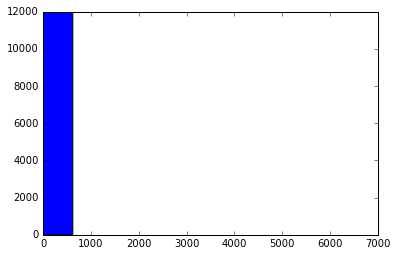

In [44]:
plt.hist(seg_dist)

In [ ]:
np.max(agg_road_bumpiness.values())

In [ ]:
plt.hist(agg_road_bumpiness.values())

In [79]:
import matplotlib.colors as colors

In [80]:
plasma = cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=1.0)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plasma)

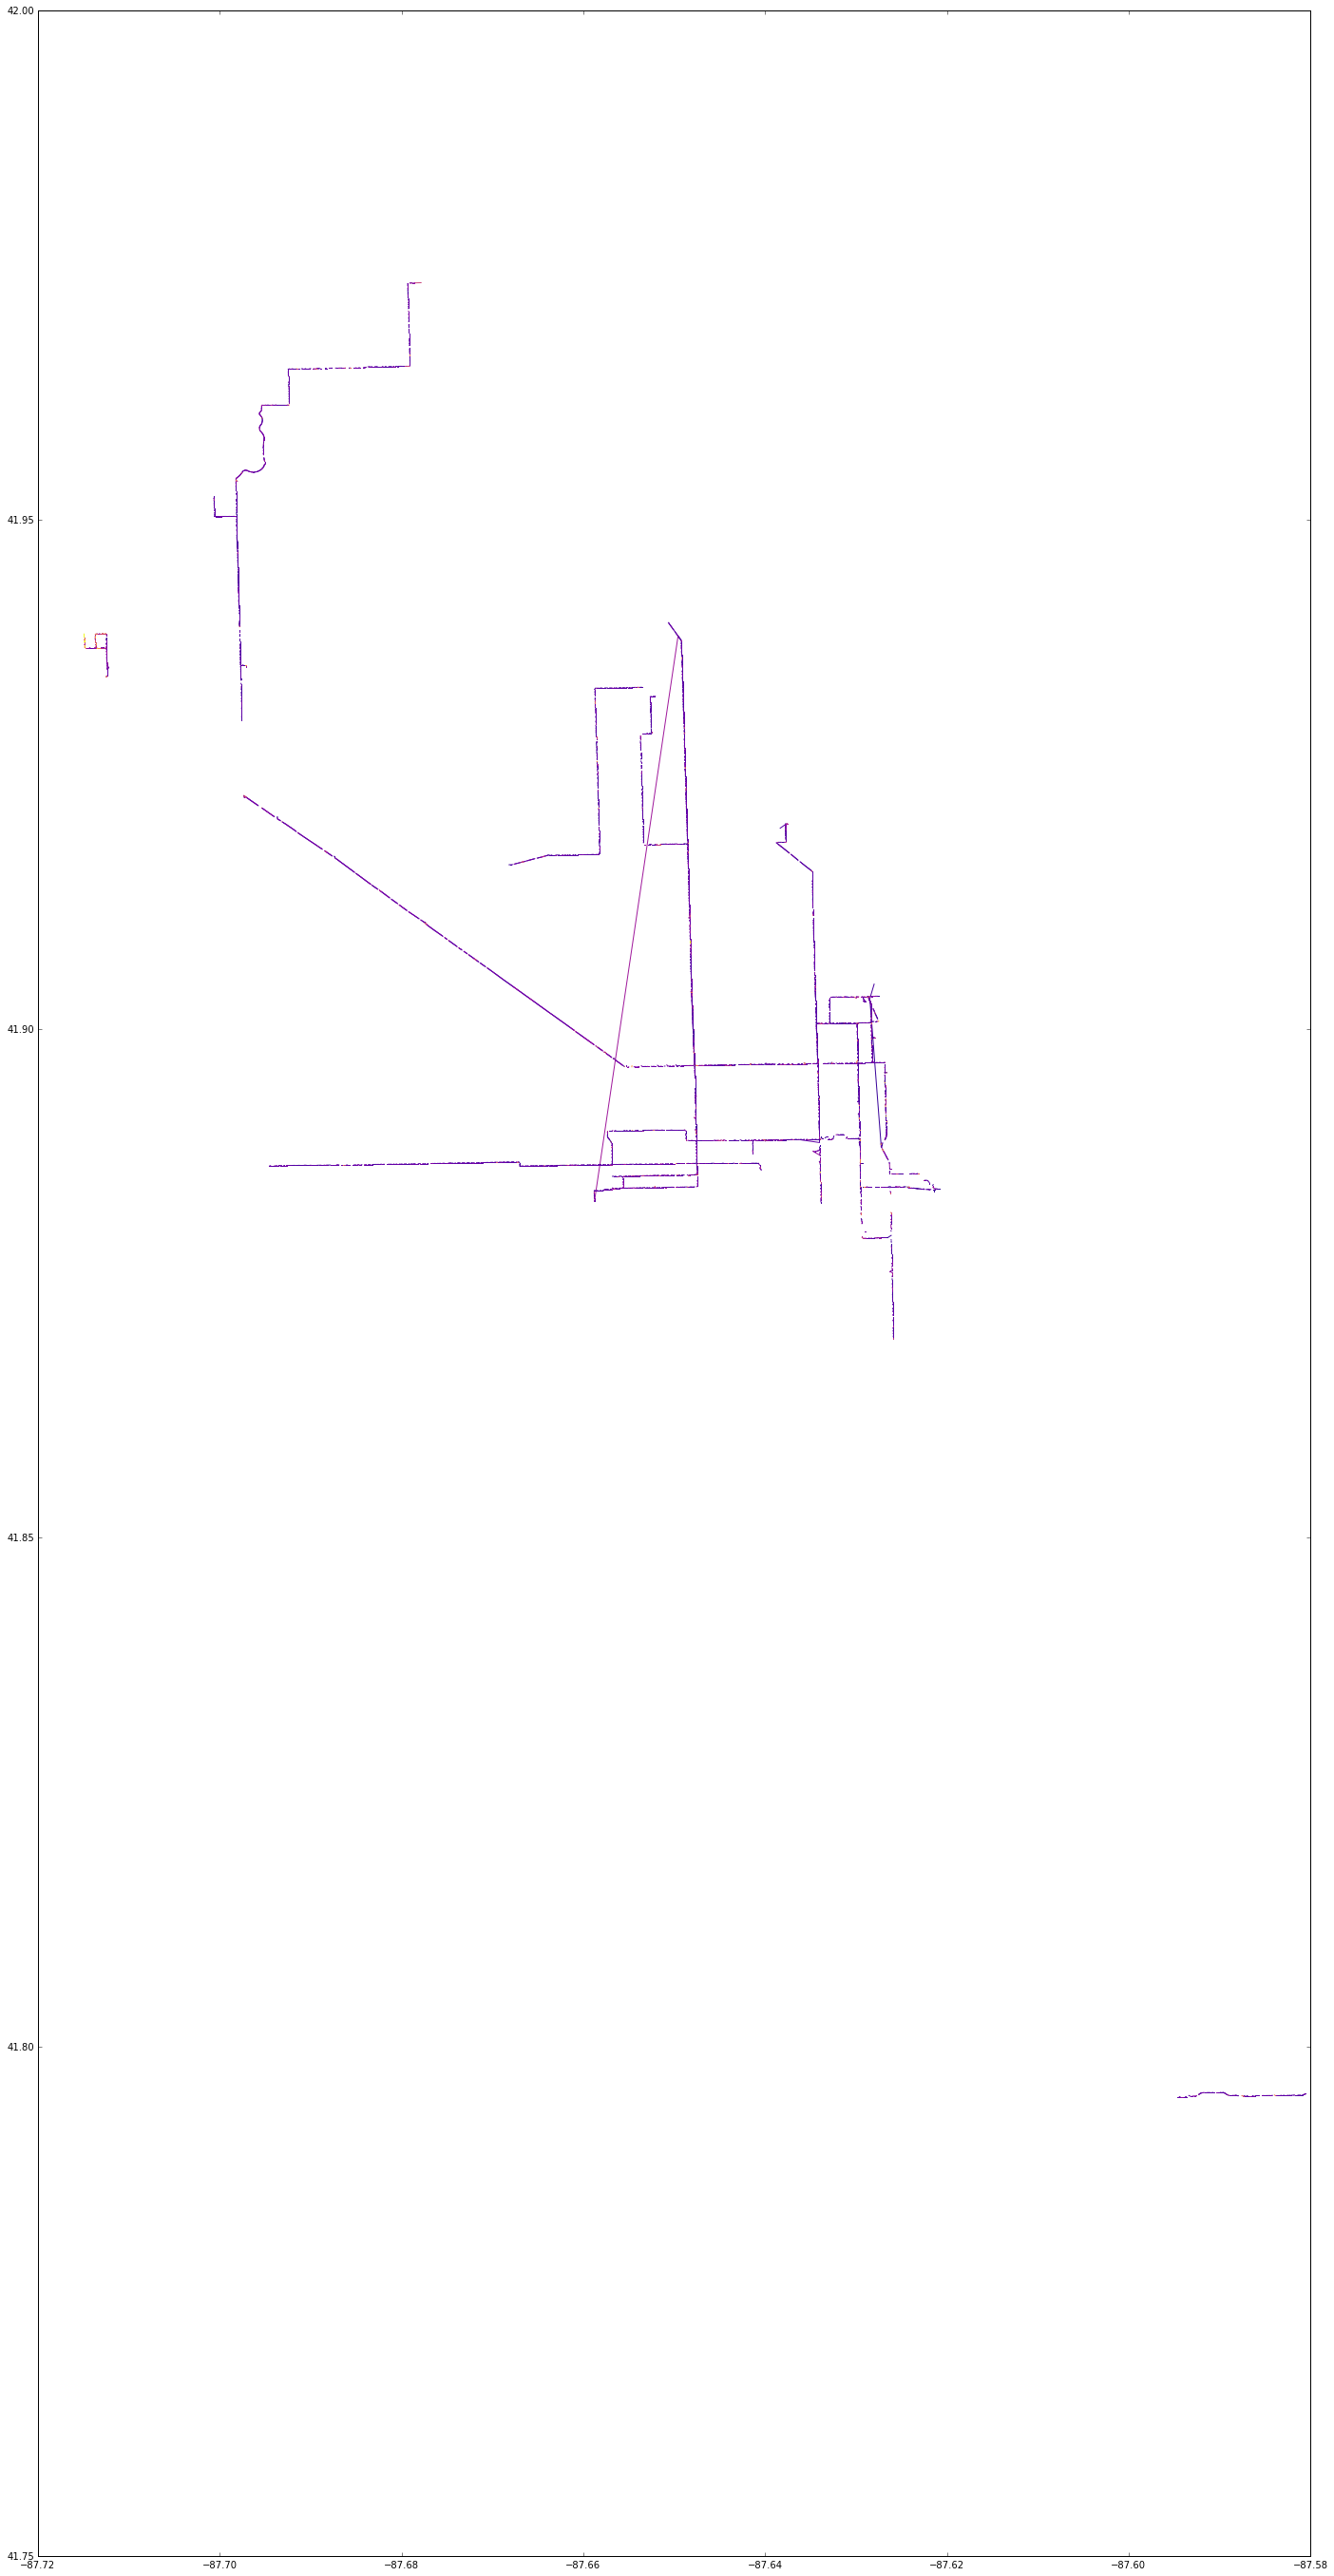

In [82]:
for osm_segment, bumpiness in agg_road_bumpiness.items():
#     lat_lon = osm_segment
#     color = (1, 0, 0) if data_munging.calc_dist(lat_lon[0][1], lat_lon[0][0], lat_lon[1][1], lat_lon[1][0]) > 100 else (0, 1, 0)
    plt.plot([osm_segment[0][1], osm_segment[1][1]],
             [osm_segment[0][0], osm_segment[1][0]],
#              color=color)
             color=scalarMap.to_rgba(bumpiness))
fig = plt.gcf()
fig.set_size_inches(24, 48)
plt.show()

In [75]:
filtered_agg_bumpiness = dict((lat_lon, agg_road_bumpiness[lat_lon])
                               for lat_lon in agg_road_bumpiness if find_seg_dist(lat_lon) < 200)

In [76]:
with open(data_dir + 'filtered_chi_road_bumpiness.txt', 'w') as f:
    f.write(str(filtered_agg_bumpiness))

In [ ]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
#     print i
#     print data 
#     osrm_request = map_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     total_calls += 1
#     if total_calls > 100:
#         break

In [ ]:
# total_calls = 0
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
#     print i
#     print data 
#     osrm_request = map_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     total_calls += 1
#     if total_calls > 100:
#         break

In [ ]:
# for i, reading in readings.iterrows():
#     data = tuple(reading[['start_lat', 'start_lon']]) + (0,) + tuple(reading[['end_lat', 'end_lon']]) + (1,)   
#     osrm_request = map_request.format(*data)
#     osrm_response = requests.get(osrm_request).json()
#     print osrm_response
#     readings.loc[i, ['snapped_start_lat', 'snapped_start_lon']] = osrm_response['matchings'][0]['matched_points'][0]
#     break